# Description

Analyze trading execution quality.

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import core.plotting as coplotti
import core.statistics as costatis
import dataflow_amp.system.Cx as dtfamsysc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.common.universe as ivcu
import oms
import oms.broker.ccxt.ccxt_aggregation_functions as obccagfu
import oms.broker.ccxt.ccxt_execution_quality as obccexqu
import oms.broker.ccxt.ccxt_logs_reader as obcclore
import oms.reconciliation as omreconc

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-b928ce05-7112-4434-b9b9-ce32bcfd28ba.json'
INFO  # Git
  branch_name='CmampTask5137_Refine_fill_stats_2'
  hash='ef0321d49'
  # Last commits:
    * ef0321d49 Paul     Lint                                                              ( 2 minutes ago) Thu Aug 24 18:59:28 2023  (HEAD -> CmampTask5137_Refine_fill_stats_2, origin/CmampTask5137_Refine_fill_stats_2)
    * f79b5ff1e paul     Checkpoint                                                        ( 7 minutes ago) Thu Aug 24 18:54:37 2023           
    * a789932bb Paul     Cmamp task5137 refine fill stats (#5155)                          (18 minutes ago) Thu Aug 24 18:43:08 2023  (origin/master, origin/HEAD, master)
# Machine info
  system=Linux
  node name=604020d06efe
  release=5.15.0-1033-aws
  version=#37~20.04.1-Ubuntu SMP Fri Mar 17 11:39:30 UTC 2023
  machine=x86_64
  processor=x86_64
  cpu count=8
  cpu freq=scpuf

# Config

In [3]:
config = cconfig.get_config_from_env()
if config:
    # Get config from env when running the notebook via the `run_notebook.py` script, e.g.,
    # in the system reconciliation flow.
    _LOG.info("Using config from env vars")
else:
    system_log_dir = "/shared_data/ecs/test/twap_experiment/20230815_1"
    id_col = "asset_id"
    universe_version = "v7.1"
    vendor = "CCXT"
    mode = "trade"
    test_asset_id = 1467591036
    bar_duration = "5T"
    expected_num_child_orders = [0, 5]
    use_historical = True
    config_dict = {
        "meta": {"id_col": id_col, "use_historical": use_historical},
        "system_log_dir": system_log_dir,
        "ohlcv_market_data": {
            "vendor": vendor,
            "mode": mode,
            "universe": {
                "universe_version": universe_version,
                "test_asset_id": test_asset_id,
            },
        },
        "execution_parameters": {
            "bar_duration": bar_duration,
            "expected_num_child_orders_per_bar": expected_num_child_orders,
        },
    }
    config = cconfig.Config.from_dict(config_dict)
print(config)

meta: 
  id_col: asset_id
  use_historical: True
system_log_dir: /shared_data/ecs/test/twap_experiment/20230815_1
ohlcv_market_data: 
  vendor: CCXT
  mode: trade
  universe: 
    universe_version: v7.1
    test_asset_id: 1467591036
execution_parameters: 
  bar_duration: 5T
  expected_num_child_orders_per_bar: [0, 5]


In [4]:
ccxt_log_reader = obcclore.CcxtLogsReader(
    config.get_and_mark_as_used(("system_log_dir",))
)

# Load Ccxt order responses and fills

In [5]:
data = ccxt_log_reader.load_all_data()
ccxt_order_response_df = data["ccxt_order_responses"]
fills_df = data["ccxt_trades"]
child_order_df = data["oms_child_orders"]

Loading files from '/shared_data/ecs/test/twap_experiment/20230815_1/ccxt_child_order_responses':   0%|       …

Loading files from '/shared_data/ecs/test/twap_experiment/20230815_1/oms_parent_orders':   0%|          | 0/5 …

Loading files from '/shared_data/ecs/test/twap_experiment/20230815_1/child_order_fills/ccxt_trades':   0%|    …

Loading files from '/shared_data/ecs/test/twap_experiment/20230815_1/oms_child_orders':   0%|          | 0/620…

Loading files from '/shared_data/ecs/test/twap_experiment/20230815_1/child_order_fills/oms_fills':   0%|      …

Loading `/shared_data/ecs/test/twap_experiment/20230815_1/child_order_fills/ccxt_fills` files...:   0%|       …

In [6]:
ccxt_order_response_df.head(3)

,info,order,client_order_id,timestamp,datetime,last_trade_timestamp,lastUpdateTimestamp,symbol,order_type,time_in_force,post_only,reduce_only,side,order_price,triggerPrice,order_amount,cost,average,filled,remaining,status,fee,trades,fees,stop_price,takeProfitPrice,stopLossPrice,order_update_timestamp,order_update_datetime
0,"{'orderId': '11982282485', 'symbol': 'GMTUSDT'...",11982282485,x-xcKtGhcud02cc15b6e79468e31f612,1692114304400,2023-08-15T15:45:04.400Z,NaN,1692114304400,GMT/USDT:USDT,limit,GTC,False,False,sell,0.2014,None,81.0,0.0,NaN,0.0,81.0,open,"{'currency': None, 'cost': None, 'rate': None}",[],"[{'currency': None, 'cost': None, 'rate': None}]",None,None,None,1692114304400,2023-08-15 15:45:04.400000+00:00
1,"{'orderId': '11982288230', 'symbol': 'GMTUSDT'...",11982288230,x-xcKtGhcuadeaf6087b202047f83888,1692114363016,2023-08-15T15:46:03.016Z,NaN,1692114363016,GMT/USDT:USDT,limit,GTC,False,False,sell,0.2015,None,81.0,0.0,NaN,0.0,81.0,open,"{'currency': None, 'cost': None, 'rate': None}",[],"[{'currency': None, 'cost': None, 'rate': None}]",None,None,None,1692114363016,2023-08-15 15:46:03.016000+00:00
2,"{'orderId': '11982292105', 'symbol': 'GMTUSDT'...",11982292105,x-xcKtGhcud9962531df2a2629a0e9f1,1692114422834,2023-08-15T15:47:02.834Z,NaN,1692114422834,GMT/USDT:USDT,limit,GTC,False,False,sell,0.2016,None,81.0,0.0,NaN,0.0,81.0,open,"{'currency': None, 'cost': None, 'rate': None}",[],"[{'currency': None, 'cost': None, 'rate': None}]",None,None,None,1692114422834,2023-08-15 15:47:02.834000+00:00


In [7]:
ccxt_order_response_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   info                    581 non-null    object             
 1   order                   581 non-null    object             
 2   client_order_id         581 non-null    object             
 3   timestamp               581 non-null    int64              
 4   datetime                581 non-null    object             
 5   last_trade_timestamp    98 non-null     float64            
 6   lastUpdateTimestamp     581 non-null    int64              
 7   symbol                  581 non-null    object             
 8   order_type              581 non-null    object             
 9   time_in_force           581 non-null    object             
 10  post_only               581 non-null    bool               
 11  reduce_only             581 non-null    bool 

In [8]:
fills_df.head(3)

,timestamp,datetime,symbol,asset_id,id,order,side,takerOrMaker,price,amount,cost,transaction_cost,fees_currency,realized_pnl,first_timestamp,last_timestamp,first_datetime,last_datetime,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-08-15 15:45:03.671000+00:00,2023-08-15 15:45:03.671000+00:00,2023-08-15 15:45:03.671000+00:00,ETH/USDT:USDT,1464553467,3178474152,8389765612601697607,sell,taker,1838.9900,0.026,47.81374,0.019125,USDT,0.0,2023-08-15 15:45:03.671000+00:00,2023-08-15 15:45:03.671000+00:00,2023-08-15 15:45:03.671000+00:00,2023-08-15 15:45:03.671000+00:00,0,1,1,0,0.0,0.026,0.026,0.0,0.0000,47.81374,47.81374,0.0000
2023-08-15 15:45:12.853000+00:00,2023-08-15 15:45:12.853000+00:00,2023-08-15 15:45:12.853000+00:00,SAND/USDT:USDT,4516629366,604613393,13944879549,buy,maker,0.3868,106.000,41.00080,0.008200,USDT,0.0,2023-08-15 15:45:12.853000+00:00,2023-08-15 15:45:12.853000+00:00,2023-08-15 15:45:12.853000+00:00,2023-08-15 15:45:12.853000+00:00,1,0,0,1,106.0,0.000,0.000,106.0,41.0008,0.00000,0.00000,41.0008
2023-08-15 15:45:05.969000+00:00,2023-08-15 15:45:05.969000+00:00,2023-08-15 15:45:05.969000+00:00,GMT/USDT:USDT,1030828978,628626142,11982282485,sell,maker,0.2014,81.000,16.31340,0.003263,USDT,0.0,2023-08-15 15:45:05.969000+00:00,2023-08-15 15:45:05.969000+00:00,2023-08-15 15:45:05.969000+00:00,2023-08-15 15:45:05.969000+00:00,0,1,0,1,0.0,81.000,0.000,81.0,0.0000,16.31340,0.00000,16.3134


In [9]:
fills_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376 entries, 2023-08-15 15:45:03.671000+00:00 to 2023-08-15 16:09:05.057000+00:00
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   timestamp         376 non-null    datetime64[ns, UTC]
 1   datetime          376 non-null    datetime64[ns, UTC]
 2   symbol            376 non-null    object             
 3   asset_id          376 non-null    int64              
 4   id                376 non-null    object             
 5   order             376 non-null    object             
 6   side              376 non-null    object             
 7   takerOrMaker      376 non-null    object             
 8   price             376 non-null    float64            
 9   amount            376 non-null    float64            
 10  cost              376 non-null    float64            
 11  transaction_cost  376 non-null    float64            
 12  f

In [10]:
test_asset_id = config.get_and_mark_as_used(
    ("ohlcv_market_data", "universe", "test_asset_id")
)
id_col = config.get_and_mark_as_used(("meta", "id_col"))
hdbg.dassert_in(test_asset_id, fills_df[id_col].to_list())

In [11]:
child_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,passivity_factor,latest_bid_price,latest_ask_price,bid_price_mean,ask_price_mean,used_bid_price,used_ask_price,exchange_timestamp,knowledge_timestamp,end_download_timestamp,limit_price,ccxt_id,name
order_id,,,,,,,,,,,,,,,,,,,,,,
29,2023-08-15 15:45:00.951630+00:00,1030828978,limit,2023-08-15 15:45:00.951630+00:00,2023-08-15 15:46:00+00:00,0.0,-81.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2013,0.2014,0.2013,0.2014,latest_bid_price,latest_ask_price,2023-08-15 15:44:57.463000+00:00,2023-08-15 15:44:57.937908+00:00,2023-08-15 15:44:57.666558+00:00,0.201355,[11982282485],29
54,2023-08-15 15:46:02.671772+00:00,1030828978,limit,2023-08-15 15:46:02.671772+00:00,2023-08-15 15:47:00+00:00,-81.0,-81.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2014,0.2015,0.2014,0.2015,latest_bid_price,latest_ask_price,2023-08-15 15:45:58.793000+00:00,2023-08-15 15:45:59.932959+00:00,2023-08-15 15:45:59.065060+00:00,0.201455,[11982288230],54
79,2023-08-15 15:47:02.495648+00:00,1030828978,limit,2023-08-15 15:47:02.495648+00:00,2023-08-15 15:48:00+00:00,-162.0,-81.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2015,0.2016,0.2015,0.2016,latest_bid_price,latest_ask_price,2023-08-15 15:46:59.252000+00:00,2023-08-15 15:46:59.547660+00:00,2023-08-15 15:46:59.472099+00:00,0.201555,[11982292105],79


In [12]:
child_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620 entries, 29 to 737
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   creation_timestamp      620 non-null    datetime64[ns, UTC]
 1   asset_id                620 non-null    int64              
 2   type_                   620 non-null    object             
 3   start_timestamp         620 non-null    datetime64[ns, UTC]
 4   end_timestamp           620 non-null    datetime64[ns, UTC]
 5   curr_num_shares         620 non-null    float64            
 6   diff_num_shares         620 non-null    float64            
 7   tz                      620 non-null    object             
 8   extra_params            620 non-null    object             
 9   passivity_factor        620 non-null    float64            
 10  latest_bid_price        620 non-null    float64            
 11  latest_ask_price        620 non-null    floa

## Aggregate by order and bar

In [13]:
bar_duration = config.get_and_mark_as_used(
    ("execution_parameters", "bar_duration")
)
# TODO(Paul): Look into adding tqdm.
# Aggregate order responses by bar.
bar_ccxt_order_aggregation = obccagfu.aggregate_ccxt_orders_by_bar(
    ccxt_order_response_df, bar_duration
)
# Aggregate fills by order.
ccxt_order_fills = obccagfu.aggregate_fills_by_order(fills_df)
# Aggregate fills by bar.
bar_fills = obccagfu.aggregate_fills_by_bar(
    fills_df, bar_duration, groupby_id_col=id_col
)
# Aggregate buy/sell trade prices by bar.
trade_prices = obccagfu.compute_buy_sell_prices_by_bar(
    fills_df, bar_duration, groupby_id_col=id_col
)

In [14]:
bar_ccxt_order_aggregation.head(3)

order_count                                                                                                                                                                                                                                                                         buy_order_count                                                                                                                                                                                                                                                                         buy_limit_twap                                                                                                                                                                                                                                                                         buy_limit_vwap                                                                                                                           \
asset_id                   1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573      1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573     1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573     1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208   
bar_end_datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2023-08-15 15:50:00+00:00           5          5          5          5          5          5          5          5          5          5          5          5          5          5          5          5          5          5          5          5          5          5          5          5          5               0          0          0          5          0          5          5          5          5          0          5          0          5          0          5          5          0          5          5          5          0          5          5          0          0            NaN        NaN        NaN   0.113340        NaN     4.9516   0.238640     1.4556   24.75960        NaN    0.28550        NaN    0.09002        NaN     7.2836    0.66616        NaN      2.163    0.38670   0.590540        NaN     2.0086    12.2488        NaN        NaN            NaN        NaN        NaN   0.113340        NaN     4.9516   0.238640     1.4556   24.75960        NaN    0.28550        NaN   
2023-08-15 15:55:00+00:00 

In [15]:
ccxt_order_fills.head(3)

,first_timestamp,last_timestamp,first_datetime,last_datetime,symbol,asset_id,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional,price,amount,cost,transaction_cost,realized_pnl
order,,,,,,,,,,,,,,,,,,,,,,,
10179280405,2023-08-15 15:45:05.673000+00:00,2023-08-15 15:45:05.673000+00:00,2023-08-15 15:45:05.673000+00:00,2023-08-15 15:45:05.673000+00:00,APE/USDT:USDT,6051632686,1,0,0,1,8.0,0.0,0.0,8.0,16.064,0.0,0.0,16.064,2.008,8.0,16.064,0.003213,0.0
10179326106,2023-08-15 15:47:19.299000+00:00,2023-08-15 15:47:19.299000+00:00,2023-08-15 15:47:19.299000+00:00,2023-08-15 15:47:19.299000+00:00,APE/USDT:USDT,6051632686,1,0,0,1,8.0,0.0,0.0,8.0,16.088,0.0,0.0,16.088,2.011,8.0,16.088,0.003218,0.0
10179347345,2023-08-15 15:48:04.471000+00:00,2023-08-15 15:48:04.471000+00:00,2023-08-15 15:48:04.471000+00:00,2023-08-15 15:48:04.471000+00:00,APE/USDT:USDT,6051632686,1,0,0,1,8.0,0.0,0.0,8.0,16.048,0.0,0.0,16.048,2.006,8.0,16.048,0.003210,0.0


In [16]:
bar_fills.head(3)

first_timestamp                   last_timestamp                   first_datetime                    last_datetime         symbol    asset_id  buy_count  sell_count  taker_count  maker_count  buy_volume  sell_volume  taker_volume  maker_volume  buy_notional  sell_notional  taker_notional  maker_notional        price   amount       cost  transaction_cost  realized_pnl
bar_end_datetime          asset_id                                                                                                                                                                                                                                                                                                                                                                                                     
2023-08-15 15:50:00+00:00 1030828978 2023-08-15 15:45:05.969000+00:00 2023-08-15 15:49:03.676000+00:00 2023-08-15 15:45:05.969000+00:00 2023-08-15 15:49:03.676000+00:00  GMT/USDT:USDT  1030828978          0           4            1            3         0.0      324.000        81.000       243.000           0.0       65.30220        16.33770         48.9645      0.20155  324.000   65.30220          0.016328           0.0
                          1464553467 2023-08-15 15:45:03.671000+00:00 2023-08-15 15:49:03.671000+00:00 2023-08-15 15:45:03.671000+00:00 2023-08-15 15:49:03.671000+00:00  ETH/USDT:USDT  1464553467          0           5            3            2         0.0        0.130         0.078         0.052           0.0      239.14488       143.50128         95.6436   1839.57600    0.130  239.14488          0.076529           0.0
                          1467591036 2023-08-15 15:46:03.013000+00:00 2023-08-15 15:49:03.674000+00:00 2023-08-15 15:46:03.013000+00:00 2023-08-15 15:49:03.674000+00:00  BTC/USDT:USDT  1467591036          0           4            3            1         0.0        0.008         0.006         0.002           0.0      234.69160       176.01440         58.6772  29336.45000    0.008  234.69160          0.082141           0.0

In [17]:
trade_prices.head(3)

buy_trade_price                                                                                                                                                                                                                                                                          sell_trade_price                                                                                                                                                                                                                                                                        
asset_id                       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
bar_end_datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2023-08-15 15:50:00+00:00             NaN        NaN        NaN   0.113200        NaN   4.949000    0.23860   1.455667    24.7590        NaN     0.2855        NaN   0.090067        NaN     7.2850   0.666225        NaN    2.16325   0.386750   0.590500        NaN   2.008333     12.250         NaN        NaN         0.201550  1839.5760   29336.45        NaN   4.391190        NaN        NaN        NaN        NaN   1.874260        NaN      0.577        NaN   5.765250        NaN        NaN   0.073712        NaN        NaN        NaN   0.624820        NaN        NaN    238.870     1.3265
2023-08-15 15:55:00+00:00        0.201667    1840.11   29343.02        NaN     4.4086        NaN        NaN        NaN        NaN   1.875625        NaN      0.577        NaN      5.771        NaN        NaN    0.07377        NaN        NaN        NaN   0.625833        NaN        NaN  239.083333      1.327              NaN        NaN        NaN    0.11375        NaN      4.957     0.2392    1.46175        NaN        NaN        NaN        NaN     0.0906        NaN     7.2925    0.66695        NaN      2.167     0.3869    0.59115        NaN      2.011     12.255        NaN        NaN
2023-08-15 16:00:00+00:00             NaN        NaN        NaN   0.113433        NaN   4.949333    0.23845   1.459667    24.7115        NaN     0.2854        NaN        NaN        NaN     7.2795   0.660460        NaN    2.16580   0.386433   0.589925        NaN   1.992000     12.229         NaN        NaN         0.201333  1839.2075   29318.35        NaN   4.402667        NaN        NaN        NaN        NaN   1.872275        NaN        NaN        NaN   5.761667        NaN        NaN   0.073632        NaN        NaN        NaN   0.625025        NaN        NaN    238.915     1.3260

In [18]:
omreconc.get_asset_slice(bar_ccxt_order_aggregation, test_asset_id)

,order_count,buy_order_count,buy_limit_twap,buy_limit_vwap,buy_amount,buy_notional,sell_order_count,sell_limit_twap,sell_limit_vwap,sell_amount,sell_notional
bar_end_datetime,,,,,,,,,,,
2023-08-15 15:50:00+00:00,5.0,0.0,NaN,NaN,NaN,NaN,5.0,29333.66,29333.66,0.01,293.3366
2023-08-15 15:55:00+00:00,5.0,5.0,29343.56,29343.56,0.005,146.7178,0.0,NaN,NaN,NaN,NaN
2023-08-15 16:00:00+00:00,5.0,0.0,NaN,NaN,NaN,NaN,5.0,29320.52,29320.52,0.01,293.2052
2023-08-15 16:05:00+00:00,5.0,5.0,29325.40,29325.40,0.005,146.6270,0.0,NaN,NaN,NaN,NaN
2023-08-15 16:10:00+00:00,5.0,5.0,29325.12,29325.12,0.010,293.2512,0.0,NaN,NaN,NaN,NaN


In [19]:
# If `order_twap` and `order_vwap` are different for a given instrument and bar,
#  then we are likely submitting orders of differing sizes.
# Use rounding to ignore machine precision artifacts.
#
# If this number is not zero, then closely inspect the dataframe (without summing
# absolute values).
bar_ccxt_order_aggregation["buy_limit_twap"].subtract(
    bar_ccxt_order_aggregation["buy_limit_vwap"]
).abs().sum().sum().round(9)

0.0

In [20]:
# Analogous check but for sells.
bar_ccxt_order_aggregation["sell_limit_twap"].subtract(
    bar_ccxt_order_aggregation["sell_limit_vwap"]
).abs().sum().sum().round(9)

0.0

### Cross-checks

In [21]:
# For a given bar and a given instrument, we expect to see either 0 (child) orders, or X child orders,
# where X is constant across the run.
# This should have counts for two values: zero and the number X of trades per bar.
bar_ccxt_order_aggregation["order_count"].stack().value_counts()

5    109
4      9
0      7
dtype: int64

#### Cross-checking the missing order count for bars

The correct number of child orders expected to be submitted for a bar is 4 per asset_id (if there is a planned submission), or 0 per asset_id (if no orders are planned to be submitted or the order notional is too small for the exchange to accept the order.

In [22]:
# Get all bars and asset_ids with inconsistent child order number.
expected_num_child_orders = config.get_and_mark_as_used(
    ("execution_parameters", "expected_num_child_orders_per_bar")
)
inconsistent_order_num_df = bar_ccxt_order_aggregation["order_count"].stack()[
    ~bar_ccxt_order_aggregation["order_count"]
    .stack()
    .isin(expected_num_child_orders)
]
inconsistent_order_num_df

bar_end_datetime           asset_id  
2023-08-15 16:00:00+00:00  1528092593    4
                           1966583502    4
                           2237530510    4
                           2384892553    4
                           2476706208    4
                           2484635488    4
                           2540896331    4
                           5115052901    4
                           9872743573    4
dtype: int64

- Most of the 2- and 3-children order submissions happen at the last bar, where there is a strict time cutoff which does not let the child orders to finish submission.

In [23]:
# Get all orders for the bars in the range where the numbers have been inconsistent.
# Note: may yield uninterpretable results if the bars are not consecutive.
if False:
    child_order_df[
        (
            child_order_df["creation_timestamp"]
            > inconsistent_order_num_df.index.min()[0]
        )
        & (
            child_order_df["creation_timestamp"]
            < inconsistent_order_num_df.index.max()[0]
        )
        & (child_order_df[id_col].isin(inconsistent_order_num_df.index[1]))
    ]

#### Check child orders with no corresponding exchange responses

In [24]:
_LOG.info(
    f"child orders in child_order_df={child_order_df.shape[0]}\nresponses in ccxt_order_response_df={ccxt_order_response_df.shape[0]}\n\
child_order_df-ccxt_order_response_df={child_order_df.shape[0]-ccxt_order_response_df.shape[0]}"
)

INFO  child orders in child_order_df=620
responses in ccxt_order_response_df=581
child_order_df-ccxt_order_response_df=39


In [25]:
# Extract ccxt_id from list.
child_order_df["ccxt_id_as_single_value"] = child_order_df["ccxt_id"].apply(
    lambda x: x[0]
)
# Get child orders that were generated but did not get an order response.no_response_orders = child_order_df[child_order_df["ccxt_id"] == "-1"]
no_response_orders = child_order_df[
    child_order_df["ccxt_id_as_single_value"] == -1
]
no_response_orders["error_msg"] = no_response_orders["extra_params"].apply(
    lambda x: x.get("error_msg", "")
)

In [26]:
# Check the error messages for child orders that did not come through.
no_response_orders["error_msg"].value_counts()

binance {"code":-4164,"msg":"Order's notional must be no smaller than 5 (unless you choose reduce only)."}    30
binance {"code":-2019,"msg":"Margin is insufficient."}                                                         9
Name: error_msg, dtype: int64

In [27]:
# Not all error messages are logged as of now, check child orders with no response and no logged error message.
no_response_orders[no_response_orders["error_msg"] == ""]

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,passivity_factor,latest_bid_price,latest_ask_price,bid_price_mean,ask_price_mean,used_bid_price,used_ask_price,exchange_timestamp,knowledge_timestamp,end_download_timestamp,limit_price,ccxt_id,name,ccxt_id_as_single_value,error_msg
order_id,,,,,,,,,,,,,,,,,,,,,,,,


In [28]:
# If `buy_count` and `sell_count` are both greater than zero for an order,
#  there is a problem.
has_buys = ccxt_order_fills["buy_count"] > 0
has_sells = ccxt_order_fills["sell_count"] > 0
# This dataframe should have zero rows.
ccxt_order_fills.loc[has_buys & has_sells].shape[0]

0

In [29]:
# If `buy_count` and `sell_count` are both greater than zero for an instrument and bar,
#  there is likely a bar alignment or timing problem.
has_buys = bar_fills["buy_count"] > 0
has_sells = bar_fills["sell_count"] > 0
# This dataframe should be empty.
bar_fills.loc[has_buys & has_sells].shape[0]

0

In [30]:
# TODO(Paul): This plotting function applies here too, even though we are working with counts
#  instead of slippage. Rename and move the plotting function.
# TODO(Paul): This plotting function doesn't seem to be idempotent.
# col = "order_count"
# coplotti.plot_boxplot(bar_ccxt_order_aggregation[col], "by_row", ylabel=col)

In [31]:
# TODO(Paul): This plotting function applies here too, even though we are working with counts
#  instead of slippage. Rename and move the plotting function.
# col = "order_count"
# coplotti.plot_boxplot(bar_ccxt_order_aggregation[col], "by_col", ylabel=col)

## Fee summary

In [32]:
group_by_col = "is_buy"
obccexqu.generate_fee_summary(fills_df, "is_buy")

is_buy,False,True,combined
fill_count,181.000000,195.000000,376.000000
traded_volume_dollars,5438.270830,5252.963760,10691.234590
fill_fees_dollars,1.361118,1.384061,2.745178
fill_fees_bps,2.502850,2.634818,2.567691
realized_pnl_dollars,1.841524,-2.531163,-0.689638
realized_pnl_bps,3.386231,-4.818542,-0.645050
is_buy,0.000000,195.000000,195.000000
is_maker,136.000000,133.000000,269.000000
is_positive_realized_pnl,68.000000,29.000000,97.000000


In [33]:
group_by_col = "is_maker"
obccexqu.generate_fee_summary(fills_df, group_by_col)

is_maker,False,True,combined
fill_count,107.000000,269.000000,376.000000
traded_volume_dollars,3034.659290,7656.575300,10691.234590
fill_fees_dollars,1.213864,1.531315,2.745178
fill_fees_bps,4.000000,2.000000,2.567691
realized_pnl_dollars,-0.048718,-0.640920,-0.689638
realized_pnl_bps,-0.160538,-0.837085,-0.645050
is_buy,62.000000,133.000000,195.000000
is_maker,0.000000,269.000000,269.000000
is_positive_realized_pnl,21.000000,76.000000,97.000000


In [34]:
group_by_col = "is_positive_realized_pnl"
obccexqu.generate_fee_summary(fills_df, group_by_col)

is_positive_realized_pnl,False,True,combined
fill_count,279.000000,97.000000,376.000000
traded_volume_dollars,8188.239960,2502.994630,10691.234590
fill_fees_dollars,2.138245,0.606933,2.745178
fill_fees_bps,2.611361,2.424827,2.567691
realized_pnl_dollars,-3.710254,3.020616,-0.689638
realized_pnl_bps,-4.531198,12.068007,-0.645050
is_buy,166.000000,29.000000,195.000000
is_maker,193.000000,76.000000,269.000000
is_positive_realized_pnl,0.000000,97.000000,97.000000


## Align ccxt orders and fills

In [35]:
filled_ccxt_orders, unfilled_ccxt_orders = obccexqu.align_ccxt_orders_and_fills(
    ccxt_order_response_df, fills_df
)

In [36]:
filled_ccxt_orders.head(3)

,order_type,time_in_force,post_only,reduce_only,side,order_price,stop_price,order_amount,order_update_timestamp,order_update_datetime,first_timestamp,last_timestamp,first_datetime,last_datetime,symbol,asset_id,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional,price,amount,cost,transaction_cost,realized_pnl
order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11982282485,limit,GTC,False,False,sell,0.2014,None,81.0,1692114304400,2023-08-15 15:45:04.400000+00:00,2023-08-15 15:45:05.969000+00:00,2023-08-15 15:45:05.969000+00:00,2023-08-15 15:45:05.969000+00:00,2023-08-15 15:45:05.969000+00:00,GMT/USDT:USDT,1030828978,0,1,0,1,0.0,81.0,0.0,81.0,0.0,16.3134,0.0,16.3134,0.2014,81.0,16.3134,0.003263,0.0
11982288230,limit,GTC,False,False,sell,0.2015,None,81.0,1692114363016,2023-08-15 15:46:03.016000+00:00,2023-08-15 15:46:21.020000+00:00,2023-08-15 15:46:21.020000+00:00,2023-08-15 15:46:21.020000+00:00,2023-08-15 15:46:21.020000+00:00,GMT/USDT:USDT,1030828978,0,1,0,1,0.0,81.0,0.0,81.0,0.0,16.3215,0.0,16.3215,0.2015,81.0,16.3215,0.003264,0.0
11982295132,limit,GTC,False,False,sell,0.2016,None,81.0,1692114482698,2023-08-15 15:48:02.698000+00:00,2023-08-15 15:48:44.361000+00:00,2023-08-15 15:48:44.361000+00:00,2023-08-15 15:48:44.361000+00:00,2023-08-15 15:48:44.361000+00:00,GMT/USDT:USDT,1030828978,0,1,0,1,0.0,81.0,0.0,81.0,0.0,16.3296,0.0,16.3296,0.2016,81.0,16.3296,0.003266,0.0


In [37]:
unfilled_ccxt_orders.head(3)

,order_type,time_in_force,post_only,reduce_only,side,order_price,stop_price,order_amount,order_update_timestamp,order_update_datetime
order,,,,,,,,,,
10179304802,limit,GTC,False,False,buy,2.010,None,8.0,1692114363021,2023-08-15 15:46:03.021000+00:00
10179373589,limit,GTC,False,False,buy,2.008,None,8.0,1692114543685,2023-08-15 15:49:03.685000+00:00
10179422607,limit,GTC,False,False,sell,2.008,None,14.0,1692114662420,2023-08-15 15:51:02.420000+00:00


In [38]:
filled_order_execution_quality = obccexqu.compute_filled_order_execution_quality(
    filled_ccxt_orders, tick_decimals=6
)
filled_order_execution_quality.head()

,direction,price_improvement_notional,price_improvement_bps,underfill_quantity,underfill_pct,underfill_notional_at_limit_price,underfill_notional_at_transaction_price
order,,,,,,,
11982282485,-1,0.0,0.0,0.0,0.0,0.0,0.0
11982288230,-1,0.0,0.0,0.0,0.0,0.0,0.0
11982295132,-1,0.0,0.0,0.0,0.0,0.0,0.0
11982299589,-1,0.0,0.0,0.0,0.0,0.0,0.0
11982309326,1,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# If any value is negative (up to machine precision), except for `direction`, there is a bug somewhere.
filled_order_execution_quality.loc[
    (filled_order_execution_quality.drop("direction", axis=1).round(9) < 0).any(
        axis=1
    )
].shape[0]

0

In [40]:
filled_order_execution_quality.min()

direction                                 -1.0
price_improvement_notional                 0.0
price_improvement_bps                      0.0
underfill_quantity                         0.0
underfill_pct                              0.0
underfill_notional_at_limit_price          0.0
underfill_notional_at_transaction_price    0.0
dtype: float64

In [41]:
filled_order_execution_quality.max()

direction                                  1.000000e+00
price_improvement_notional                 2.700000e+00
price_improvement_bps                      2.003005e+01
underfill_quantity                         1.776357e-15
underfill_pct                              1.629685e-16
underfill_notional_at_limit_price          7.796430e-15
underfill_notional_at_transaction_price    7.803112e-15
dtype: float64

# Load internal parent and child orders

These are in the internal `amp` format (not the `ccxt` format)

In [42]:
parent_order_df = ccxt_log_reader.load_oms_parent_order_df()

Loading files from '/shared_data/ecs/test/twap_experiment/20230815_1/oms_parent_orders':   0%|          | 0/5 …

In [43]:
parent_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
order_id,,,,,,,,,
0,2023-08-15 15:45:00+00:00,1464553467,price@twap,2023-08-15 15:45:00+00:00,2023-08-15 15:50:00+00:00,0.0,-0.128214,UTC,{'stats': {'submit_twap_orders::start': 2023-0...
1,2023-08-15 15:45:00+00:00,1467591036,price@twap,2023-08-15 15:45:00+00:00,2023-08-15 15:50:00+00:00,0.0,-0.008129,UTC,{'stats': {'submit_twap_orders::start': 2023-0...
2,2023-08-15 15:45:00+00:00,4516629366,price@twap,2023-08-15 15:45:00+00:00,2023-08-15 15:50:00+00:00,0.0,530.733019,UTC,{'stats': {'submit_twap_orders::start': 2023-0...


In [44]:
parent_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 619
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   creation_timestamp  125 non-null    datetime64[ns, UTC]
 1   asset_id            125 non-null    int64              
 2   type_               125 non-null    object             
 3   start_timestamp     125 non-null    datetime64[ns, UTC]
 4   end_timestamp       125 non-null    datetime64[ns, UTC]
 5   curr_num_shares     125 non-null    float64            
 6   diff_num_shares     125 non-null    float64            
 7   tz                  125 non-null    object             
 8   extra_params        125 non-null    object             
dtypes: datetime64[ns, UTC](3), float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [45]:
number_of_bars = int(
    np.ceil(
        (
            parent_order_df["end_timestamp"].max()
            - parent_order_df["start_timestamp"].min()
        )
        / bar_duration
    )
)
_LOG.info("number of bars=%d", number_of_bars)

INFO  number of bars=5


In [46]:
unique_asset_id_count = len(parent_order_df["asset_id"].unique())
_LOG.info("unique asset_id count=%d", unique_asset_id_count)

INFO  unique asset_id count=25


In [47]:
# Share counts should change if there are many orders and we are getting fills.
costatis.compute_moments(parent_order_df["curr_num_shares"])

mean         12.877928
std         261.127496
skew         -1.285490
kurtosis     15.758125
Name: curr_num_shares, dtype: float64

In [48]:
child_order_df = ccxt_log_reader.load_oms_child_order_df()

Loading files from '/shared_data/ecs/test/twap_experiment/20230815_1/oms_child_orders':   0%|          | 0/620…

In [49]:
child_order_df.head()

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,passivity_factor,latest_bid_price,latest_ask_price,bid_price_mean,ask_price_mean,used_bid_price,used_ask_price,exchange_timestamp,knowledge_timestamp,end_download_timestamp,limit_price,ccxt_id,name
order_id,,,,,,,,,,,,,,,,,,,,,,
29,2023-08-15 15:45:00.951630+00:00,1030828978,limit,2023-08-15 15:45:00.951630+00:00,2023-08-15 15:46:00+00:00,0.0,-81.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2013,0.2014,0.2013,0.2014,latest_bid_price,latest_ask_price,2023-08-15 15:44:57.463000+00:00,2023-08-15 15:44:57.937908+00:00,2023-08-15 15:44:57.666558+00:00,0.201355,[11982282485],29
54,2023-08-15 15:46:02.671772+00:00,1030828978,limit,2023-08-15 15:46:02.671772+00:00,2023-08-15 15:47:00+00:00,-81.0,-81.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2014,0.2015,0.2014,0.2015,latest_bid_price,latest_ask_price,2023-08-15 15:45:58.793000+00:00,2023-08-15 15:45:59.932959+00:00,2023-08-15 15:45:59.065060+00:00,0.201455,[11982288230],54
79,2023-08-15 15:47:02.495648+00:00,1030828978,limit,2023-08-15 15:47:02.495648+00:00,2023-08-15 15:48:00+00:00,-162.0,-81.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2015,0.2016,0.2015,0.2016,latest_bid_price,latest_ask_price,2023-08-15 15:46:59.252000+00:00,2023-08-15 15:46:59.547660+00:00,2023-08-15 15:46:59.472099+00:00,0.201555,[11982292105],79
104,2023-08-15 15:48:02.351981+00:00,1030828978,limit,2023-08-15 15:48:02.351981+00:00,2023-08-15 15:49:00+00:00,-162.0,-81.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2015,0.2016,0.2015,0.2016,latest_bid_price,latest_ask_price,2023-08-15 15:48:00.743000+00:00,2023-08-15 15:48:01.135911+00:00,2023-08-15 15:48:01.062472+00:00,0.201555,[11982295132],104
129,2023-08-15 15:49:03.334126+00:00,1030828978,limit,2023-08-15 15:49:03.334126+00:00,2023-08-15 15:50:00+00:00,0.0,-81.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2016,0.2017,0.2016,0.2017,latest_bid_price,latest_ask_price,2023-08-15 15:49:00.012000+00:00,2023-08-15 15:49:00.224479+00:00,2023-08-15 15:49:00.180430+00:00,0.201655,[11982299589],129


In [50]:
child_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620 entries, 29 to 737
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   creation_timestamp      620 non-null    datetime64[ns, UTC]
 1   asset_id                620 non-null    int64              
 2   type_                   620 non-null    object             
 3   start_timestamp         620 non-null    datetime64[ns, UTC]
 4   end_timestamp           620 non-null    datetime64[ns, UTC]
 5   curr_num_shares         620 non-null    float64            
 6   diff_num_shares         620 non-null    float64            
 7   tz                      620 non-null    object             
 8   extra_params            620 non-null    object             
 9   passivity_factor        620 non-null    float64            
 10  latest_bid_price        620 non-null    float64            
 11  latest_ask_price        620 non-null    floa

In [51]:
# The number of internal child orders should equal the number of ccxt order responses.
# (The difference should be zero.)
_LOG.info("Num child orders=%d", child_order_df.shape[0])
_LOG.info(
    "Num ccxt order responses=%d", ccxt_order_response_df["order"].nunique()
)
_LOG.info(
    "Num child orders minus num ccxt order responses=%d",
    child_order_df.shape[0] - ccxt_order_response_df["order"].nunique(),
)

INFO  Num child orders=620
INFO  Num ccxt order responses=581
INFO  Num child orders minus num ccxt order responses=39


In [52]:
bar_child_order_aggregation = obccagfu.aggregate_child_limit_orders_by_bar(
    child_order_df, bar_duration
)

In [53]:
bar_child_order_aggregation.head(3)

order_count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            buy_order_count                                                                                                                                                                                                                                                                         buy_limit_twap                                                                                                                           \
asset_id                   1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573      1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573     1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208   
bar_end_datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2023-08-15 15:50:00+00:00           0          0          0          5          0          5          5          5          5          0          5          0          5          0          5          5          0          5          5          5          0          5          5          0          0          5          5          5          0          5          0          0          0          0          5          0          5          0          5          0          0          5          0          0          0          5          0          0          5          5               0          0          0          5          0          5          5          5          5          0          5          0          5          0          5          5          0          5          5          5          0          5          5          0          0            NaN        NaN        NaN   0.113385        NaN    4.95205   0.238685    1.45605   24.76005        NaN   0.285545        NaN   
2023-08-15 15:55:00+00:00           5     

In [54]:
bar_child_order_aggregation.columns.levels[0].to_list()

['order_count',
 'buy_order_count',
 'buy_limit_twap',
 'buy_limit_vwap',
 'buy_amount',
 'buy_notional',
 'sell_order_count',
 'sell_limit_twap',
 'sell_limit_vwap',
 'sell_amount',
 'sell_notional']

# Load OHLCV data

In [55]:
# TODO(Paul): Refine the cuts around the first and last bars.
start_timestamp = bar_fills["first_datetime"].min() - pd.Timedelta(bar_duration)
_LOG.info("start_timestamp=%s", start_timestamp)
end_timestamp = bar_fills["last_datetime"].max()
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2023-08-15 15:40:03.671000+00:00
INFO  end_timestamp=2023-08-15 16:09:47.960000+00:00


In [56]:
universe_version = config.get_and_mark_as_used(
    ("ohlcv_market_data", "universe", "universe_version")
)
vendor = config.get_and_mark_as_used(
    (
        "ohlcv_market_data",
        "vendor",
    )
)
mode = config.get_and_mark_as_used(
    (
        "ohlcv_market_data",
        "mode",
    )
)
# Get asset ids.
asset_ids = ivcu.get_vendor_universe_as_asset_ids(universe_version, vendor, mode)
# Get prod `MarketData`.
market_data = dtfamsysc.get_Cx_RealTimeMarketData_prod_instance1(asset_ids)
# Load and resample OHLCV data.
ohlcv_bars = dtfamsysc.load_and_resample_ohlcv_data(
    market_data,
    start_timestamp,
    end_timestamp,
    bar_duration,
)

INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
File '/app/amp/im_v2/devops/env/prod.im_db_config.env' doesn't exist
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: prod.im_data_db.read_only
INFO  Created prod DB connection: 
 None


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  fit_intervals=[(Timestamp('2023-08-15 15:40:03.671000+0000', tz='UTC'), Timestamp('2023-08-15 16:09:47.960000+0000', tz='UTC'))]


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [57]:
ohlcv_bars.head(3)

close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                      \
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488   
end_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2023-08-15 11:45:00-04:00     0.2014    1838.81    29325.5     0.1133      4.389      4.949     0.2386      1.458     24.745     1.8732     0.2854      0.576     0.0898      5.764      7.280     0.6660    0.07370      2.162     0.3868     0.5899     0.6247      2.009     12.246     238.79      1.327     0.2015    1839.20    29346.0     0.1135      4.408      4.957     0.2391      1.461     24.754     1.8751     0.2856      0.578     0.0902      5.771      7.287     0.6664    0.07378      2.165     0.3872     0.5911     0.6253      2.016     12.264     238.90      1.327     0.2011     1838.5    29306.5     0.1129      4.366      4.949     0.2385      1.446     24.704     1.8720     0.2851      0.576     0.0896      5.762      7.274     0.6654    0.07362      2.161     0.3867     0.5896     0.6242      2.005     12.243     238.75      1.326     0.2015    1839.00    29342.0     0.1134      4.408      4.956     0.2391      1.450     24.749     1.8751     0.2855      0.577     0.0902   
2023-08-15 11:50:00-04:00     0.2017    184

# Compare bar trade prices to OHLCV TWAP

In [58]:
actual_and_ohlcv_price_df = {
    "buy_trade_price": trade_prices["buy_trade_price"],
    "sell_trade_price": trade_prices["sell_trade_price"],
    "twap": ohlcv_bars["twap"],
    "high": ohlcv_bars["high"],
    "low": ohlcv_bars["low"],
}
actual_and_ohlcv_price_df = pd.concat(actual_and_ohlcv_price_df, axis=1)
actual_and_ohlcv_price_df.head()

buy_trade_price                                                                                                                                                                                                                                                                               sell_trade_price                                                                                                                                                                                                                                                                               twap                                                                                                                                                                                                                                                                               high                                                                                                                \
asset_id                       1030828978   1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589   
2023-08-15 15:45:00+00:00             NaN          NaN           NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN        NaN              NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN    0.20136   1838.812   29326.26    0.11322     4.3870     4.9516    0.23872     1.4554    24.7364    1.87332    0.28544     0.5766    0.08984     5.7666     7.2808    0.66606   0.073720     2.1632    0.38692    0.59014    0.62480     2.0104    12.2518    238.818     1.3270     0.2015    1839.20    29346.0     0.1135      4.408      4.957     0.2391      1.461     24.754     1.8751     0.2856   
2023-08-15 15:50:00+00:00             NaN          NaN           NaN   0.113200        NaN   4.949000    0.23860   1.455667    24.7590        NaN     0.2855        NaN   0.090067        NaN     7.2850   0.666225        NaN    2.16325   0.386750   0.590500        NaN   2.008333     12.250         NaN        NaN         0.201550  1839.5760   29336.45        NaN   4.391190        NaN        NaN        NaN        NaN   1.874260        NaN      0.577        NaN   5.765250        NaN        NaN   0.073712        NaN        NaN        NaN   0.624820        NaN        NaN    238.870     1.3265    0.20158   1839.690   29336.38    0.11348     4.3934     4.9532    0.23878     1.4566    24.7658    1.87446    0.28566     0.5766    0.09022     5.7658     7.2862    0.66636   0.073722     2.1640    0.38680    0.59076    0.62488     2.0098    12.2520    238.904     1.3268     0.2018    1840.78    29348.8     0.1137      4.408      4.957     0.2392      1.465     24.796     1.8761     0.2860   
2023-08-15 15:55:00+00:00        0.201667  1840.110000  29

In [59]:
actual_vs_ohlcv_execution_df = cofinanc.compute_ref_price_execution_quality(
    actual_and_ohlcv_price_df,
    "twap",
    "twap",
    "buy_trade_price",
    "sell_trade_price",
)
actual_vs_ohlcv_execution_df.head()

buy_trade_slippage_notional                                                                                                                                                                                                                                                                         buy_trade_slippage_bps                                                                                                                                                                                                                                                                         sell_trade_slippage_notional                                                                                                                                                                                                                                                                         sell_trade_slippage_bps                                                                    \
asset_id                                   1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573             1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                   1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573              1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502   
2023-08-15 15:45:00+00:00                         NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                          NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                     NaN        NaN        NaN        NaN        NaN        NaN        NaN   
2023-08-15 15:50:00+00:00                         NaN        NaN        NaN  -0.000280        NaN  -0.004200   -0.00018  -0.000933    -0.0068        NaN   -0.00016        NaN  -0.000153        NaN    -0.0012  -0.000135        NaN   -0.00075  -0.000050  -0.000260        NaN  -0.001467    -0.0020        NaN        NaN                    NaN        NaN        NaN -24.673951        NaN  -8.479367  -7.538320  -6.407616  -2.745722        NaN  -5.601064        NaN -16.995492        NaN  -1.646949  -2.025932        NaN  -3.465804  -1.292658  -4.401110        NaN  -7.297575  -1.632387        NaN        NaN                     0.000030     0.1140      -0.07        NaN   0.002210        NaN        NaN        NaN        NaN   0.000200        NaN    -0.0004        NaN   0.000550        NaN        NaN   0.000010        NaN        NaN        NaN   0.000060        NaN        NaN      0.034     0.0003                1.488243   0.619670  -0.023861        NaN   5.029437        NaN        NaN   
2023-08-15 15:55:00+00:00                    0.000047   0.1740

In [60]:
actual_vs_ohlcv_execution_df.columns.levels[0].to_list()

['buy_trade_slippage_notional',
 'buy_trade_slippage_bps',
 'sell_trade_slippage_notional',
 'sell_trade_slippage_bps']

<Axes: >

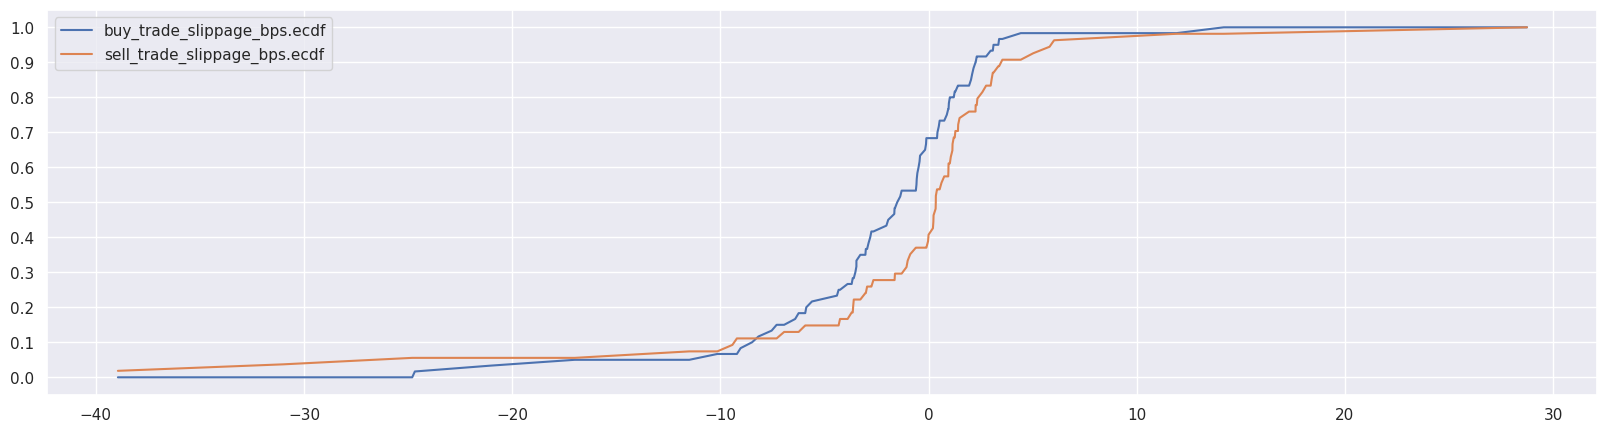

In [61]:
buy_trade_slippage_bps = (
    actual_vs_ohlcv_execution_df["buy_trade_slippage_bps"]
    .unstack()
    .rename("buy_trade_slippage_bps")
)
sell_trade_slippage_bps = (
    actual_vs_ohlcv_execution_df["sell_trade_slippage_bps"]
    .unstack()
    .rename("sell_trade_slippage_bps")
)
buy_sell_trade_slippage_bps_ecdf = costatis.compute_and_combine_empirical_cdfs(
    [buy_trade_slippage_bps, sell_trade_slippage_bps]
)
buy_sell_trade_slippage_bps_ecdf.plot(yticks=np.arange(0, 1.1, 0.1))

<Axes: >

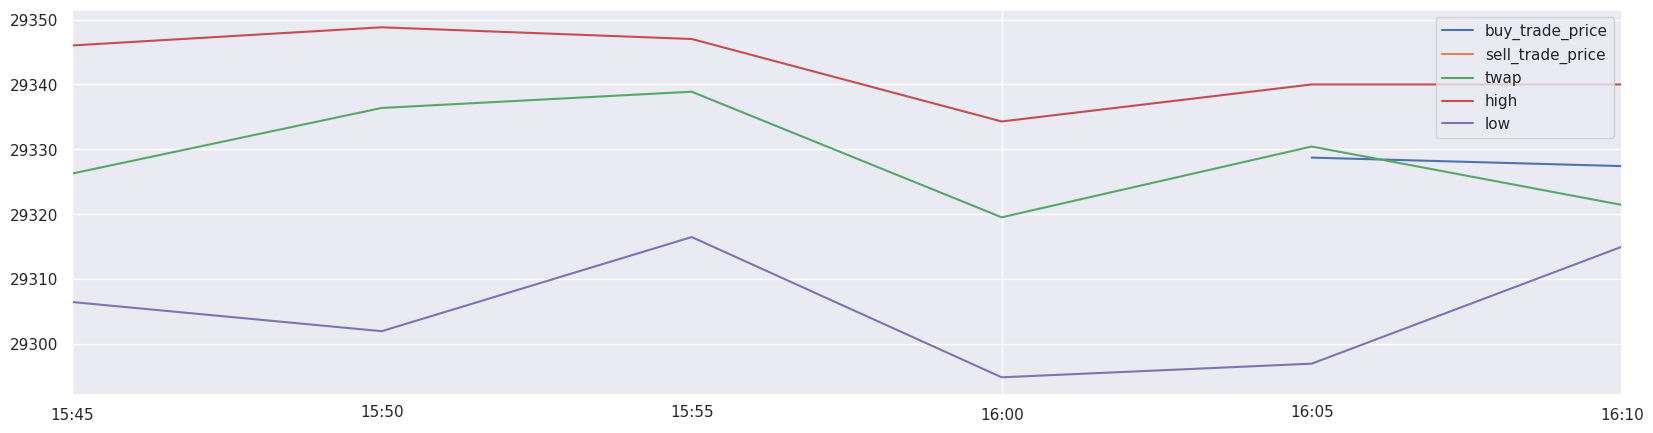

In [62]:
omreconc.get_asset_slice(actual_and_ohlcv_price_df, test_asset_id).plot()

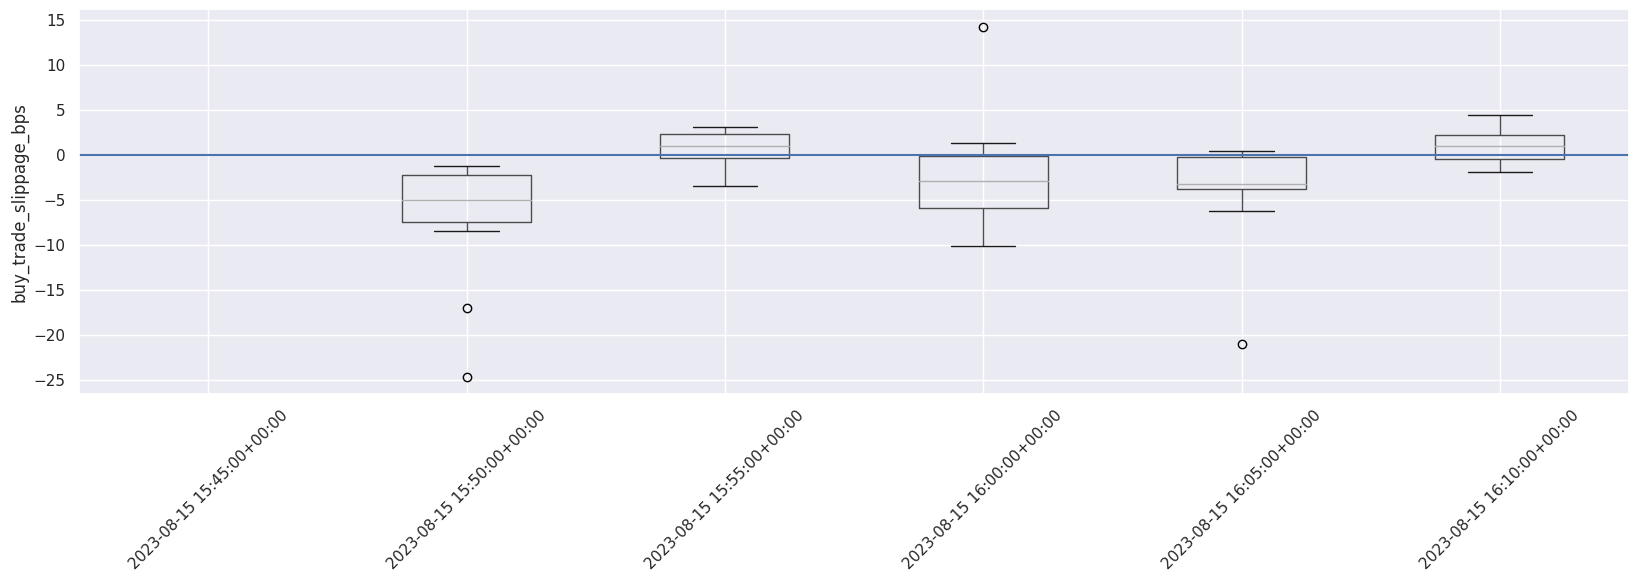

In [63]:
col = "buy_trade_slippage_bps"
coplotti.plot_boxplot(actual_vs_ohlcv_execution_df[col], "by_row", ylabel=col)

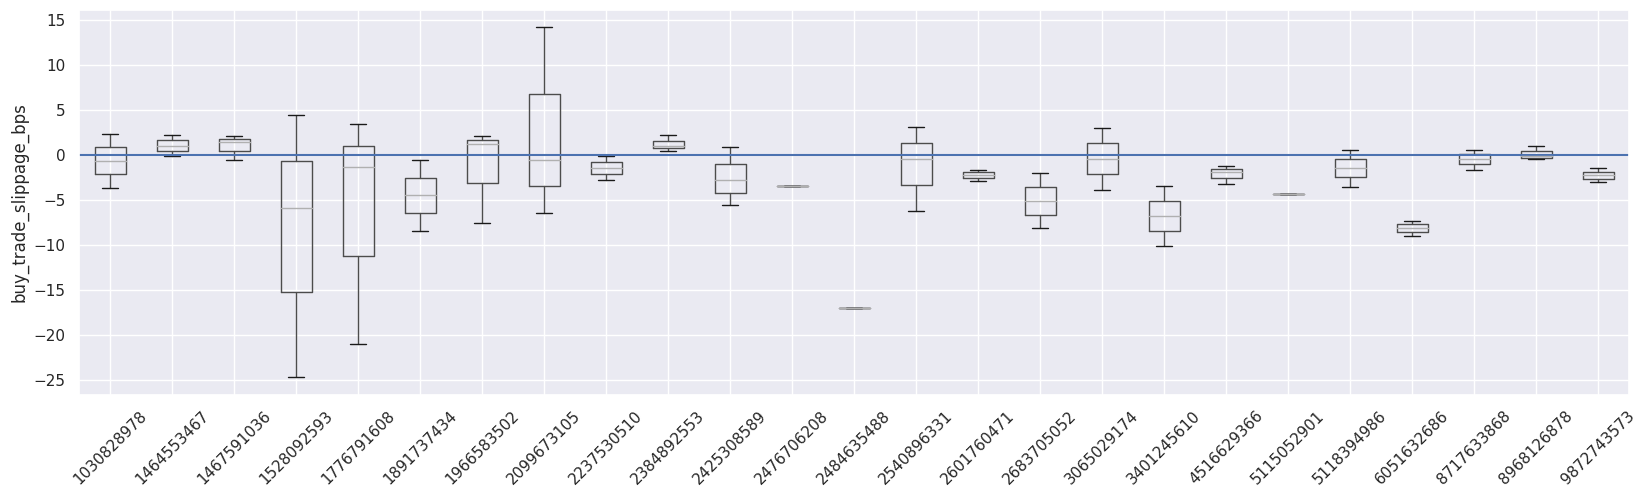

In [64]:
coplotti.plot_boxplot(actual_vs_ohlcv_execution_df[col], "by_col", ylabel=col)

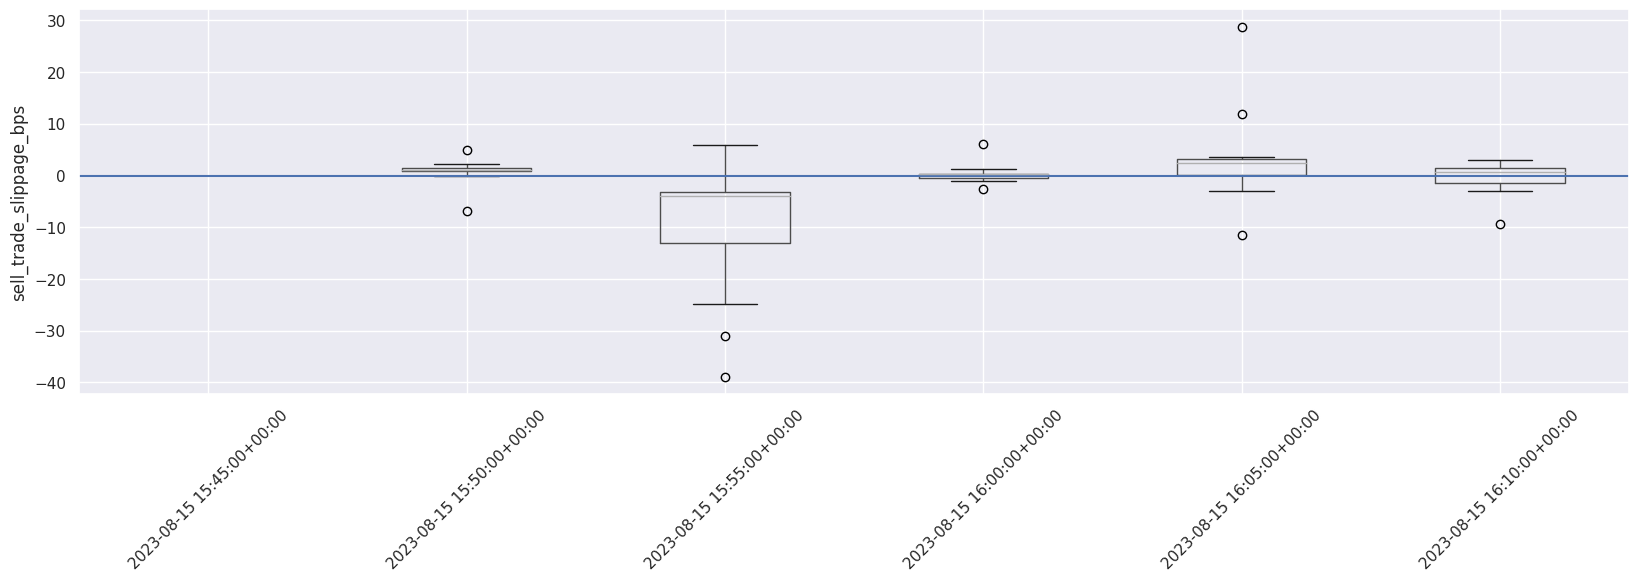

In [65]:
col = "sell_trade_slippage_bps"
coplotti.plot_boxplot(actual_vs_ohlcv_execution_df[col], "by_row", ylabel=col)

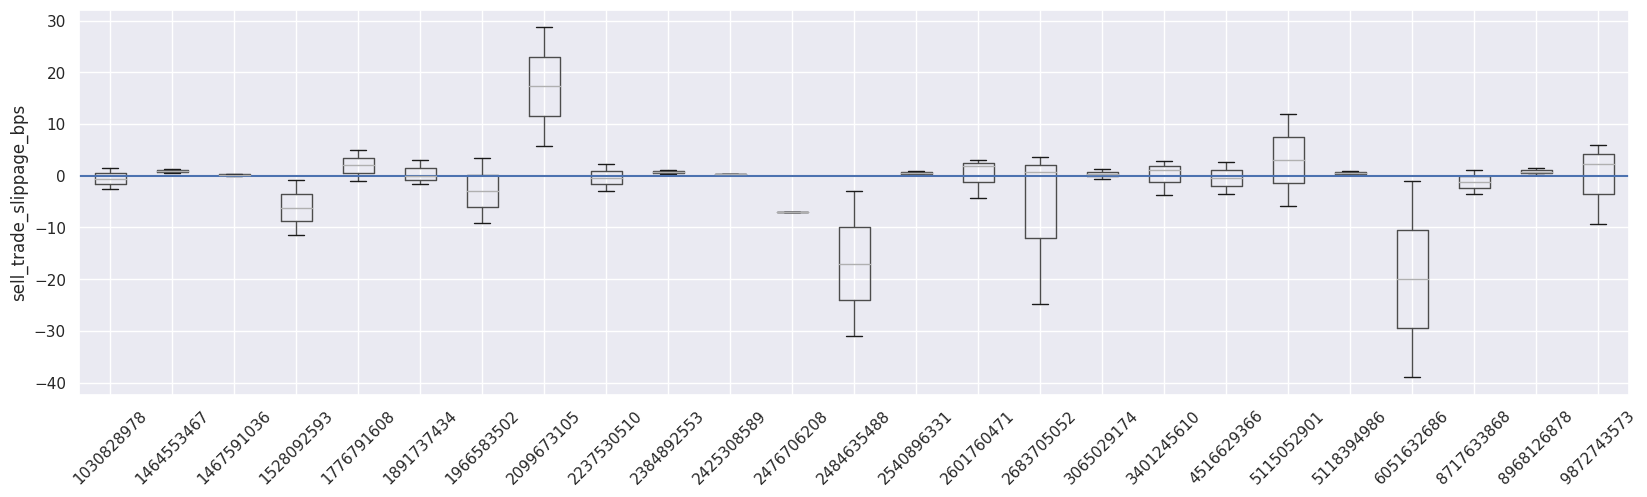

In [66]:
coplotti.plot_boxplot(actual_vs_ohlcv_execution_df[col], "by_col", ylabel=col)

# Construct portfolio, target positions and compute execution quality

## Compute `target_position_df`

In [67]:
target_position_df = obccexqu.convert_parent_orders_to_target_position_df(
    parent_order_df,
    ohlcv_bars["twap"],
)

In [68]:
fills = oms.compute_fill_stats(target_position_df)
hpandas.df_to_str(fills, num_rows=5, log_level=logging.INFO)

executed_trades_shares                                                                                                                                                                                                                                                                          fill_rate                                                                                                                                                                                                                                                                         underfill_share_count                                                                                                                                                                                                                                                                                    underfill_notional_opportunity_cost_realized                                                                                                                                                                                                                                                                         underfill_notional_opportunity_cost                                                                                                                                                                                                                                                                         tracking_error_shares                                                                                                                                                                                                                                                                                         tracking_error_notional                                                                                                                                                                                                                                                                                                tracking_error_bps                                                                                                                                                                                                                                                                                                                                                   is_buy                                                                                                                                                                                                                                                                            is_sell                                                                                                                                                                                                                                                                         is_benchmark_profitable                                                                                                                                                                                                                                                                        
asset_id                              1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573            1030828978 1464553467 1467591036   1528092593 1776791608 1891737434  1966583502 2099673105 2237530510 2384892553  2425308589  247

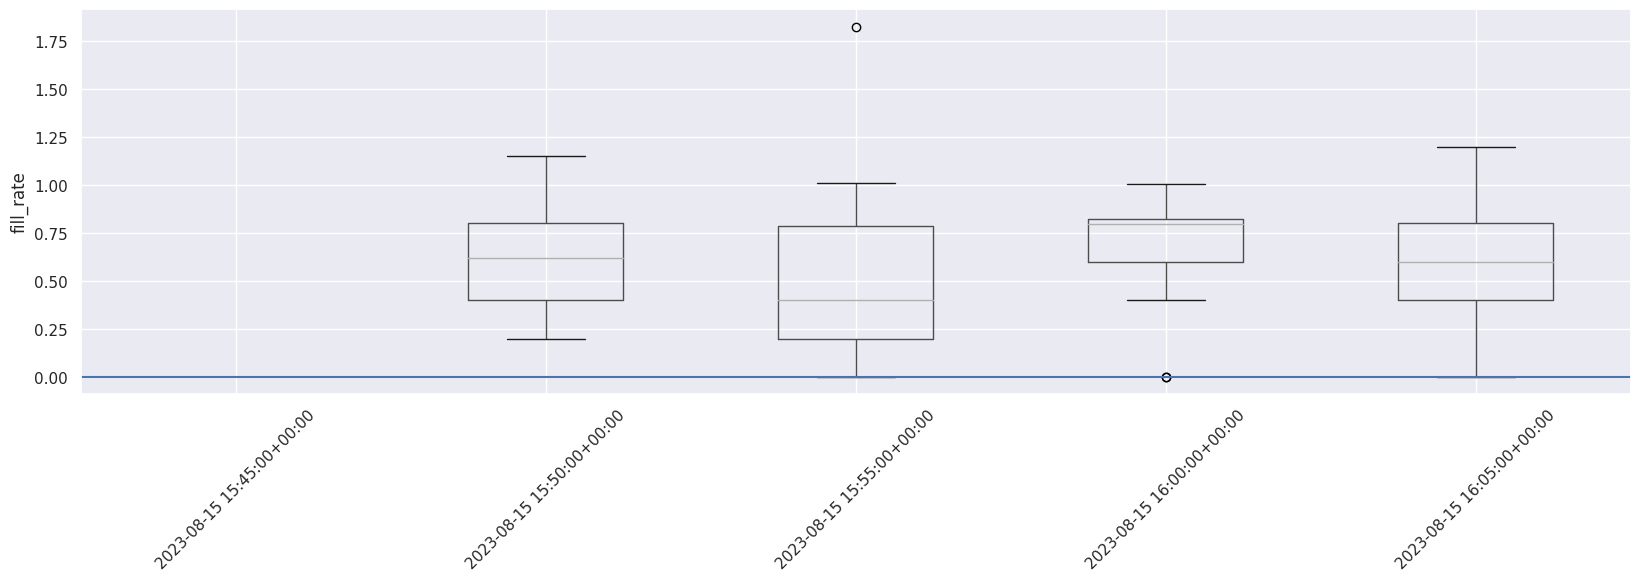

In [69]:
col = "fill_rate"
coplotti.plot_boxplot(fills[col], "by_row", ylabel=col)

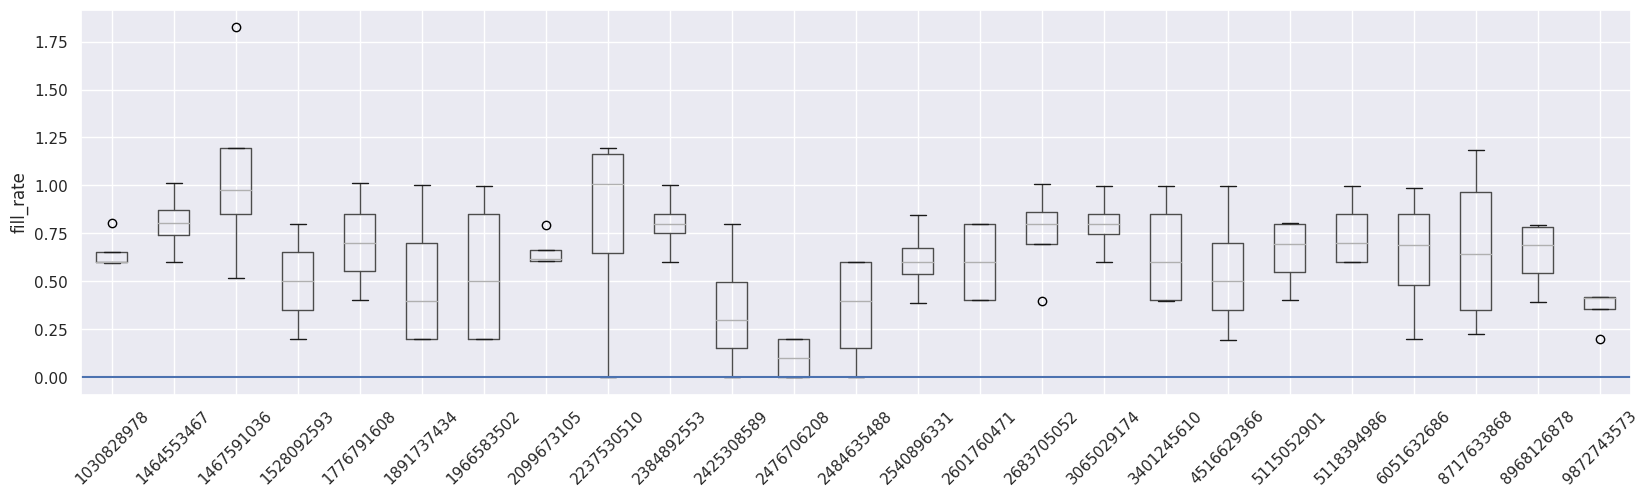

In [70]:
col = "fill_rate"
coplotti.plot_boxplot(fills[col], "by_col", ylabel=col)

## Compute `portfolio_df`

In [71]:
portfolio_df = obccexqu.convert_bar_fills_to_portfolio_df(
    bar_fills,
    ohlcv_bars["twap"],
)

In [72]:
portfolio_df.head()

holdings_notional                                                                                                                                                                                                                                                                             holdings_shares                                                                                                                                                                                                                                                                         executed_trades_notional                                                                                                                                                                                                                                                                         executed_trades_shares                                                                                          \
asset_id                         1030828978  1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510  2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052  3065029174 3401245610 4516629366 5115052901  5118394986 6051632686 8717633868 8968126878 9872743573      1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573               1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573             1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510   
2023-08-15 15:45:00+00:00           0.00000    0.000000    0.00000    0.00000    0.00000    0.00000    0.00000     0.0000     0.0000    0.000000    0.00000    0.00000    0.00000     0.0000   0.000000    0.00000    0.000000    0.00000    0.00000    0.00000    0.000000     0.0000     0.0000    0.00000     0.0000             NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                      NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN   
2023-08-15 15:50:00+00:00         -65.31192 -239.159700 -234.69104   46.98072 -191.55224   17.33620   23.63922    56.8074   247.6580 -136.835580   35.42184  -31.54002   59.81586  -115.3160  88.163020  101.28672 -121.493856  179.17920   82.00160   47.85156  -89.982720    48.2352    73.5120 -172.01088   -34.4968          -324.0     -0.130     -0.008      414.0      -43.6        3.5       99.0       39.0       10.0      -73.0      124.0      -54.7      663.0      -20.0      12.10      152.0    -1648.0       82.8      212.0       81.0     -144.0       24.0        6.0      -0.72      -26.0                 -65.3022 -239.14488  -234.6916    46.8648  -191.4559    17.3215    23.6214     56.771    247.590 -136.82098    35.4020   -31.5619    59.7142   -115.305   88.14850   101.2662 -121.47820   179.1171    81.9910    47.8305  -89.97408     48.200     73.500  -171.9864    -34.489                 -324.0     -0.130     -0.008      414.0      -43.6        3.5       99.0       39.0       10.0   
2023-08-15 15:55:00+00:00         -24.79926  -

holdings_price_per_share                                                                                                                                                                                                                                                                         trade_price_per_share                                                                                                                                                                                                                                                                              slippage_notional                                                                                                                                                                                                                                                                         slippage_notional_per_share                                                                                                                                                                                                                                                                         slippage_in_bps                                                                                                                                                                                                                                                                         benchmark_return_notional                                                                                                                                                                                                                                                                         benchmark_return_in_bps                                                                                                                                                                                                                                                                             is_buy                                                                                                                                                                                                                                                                            is_sell                                                                                                                                                                                                                                                                         is_benchmark_profitable                                                                                                                                                                                                                                                                        
asset_id                                1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573            1030828978   1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573        1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                  1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 871

<Axes: >

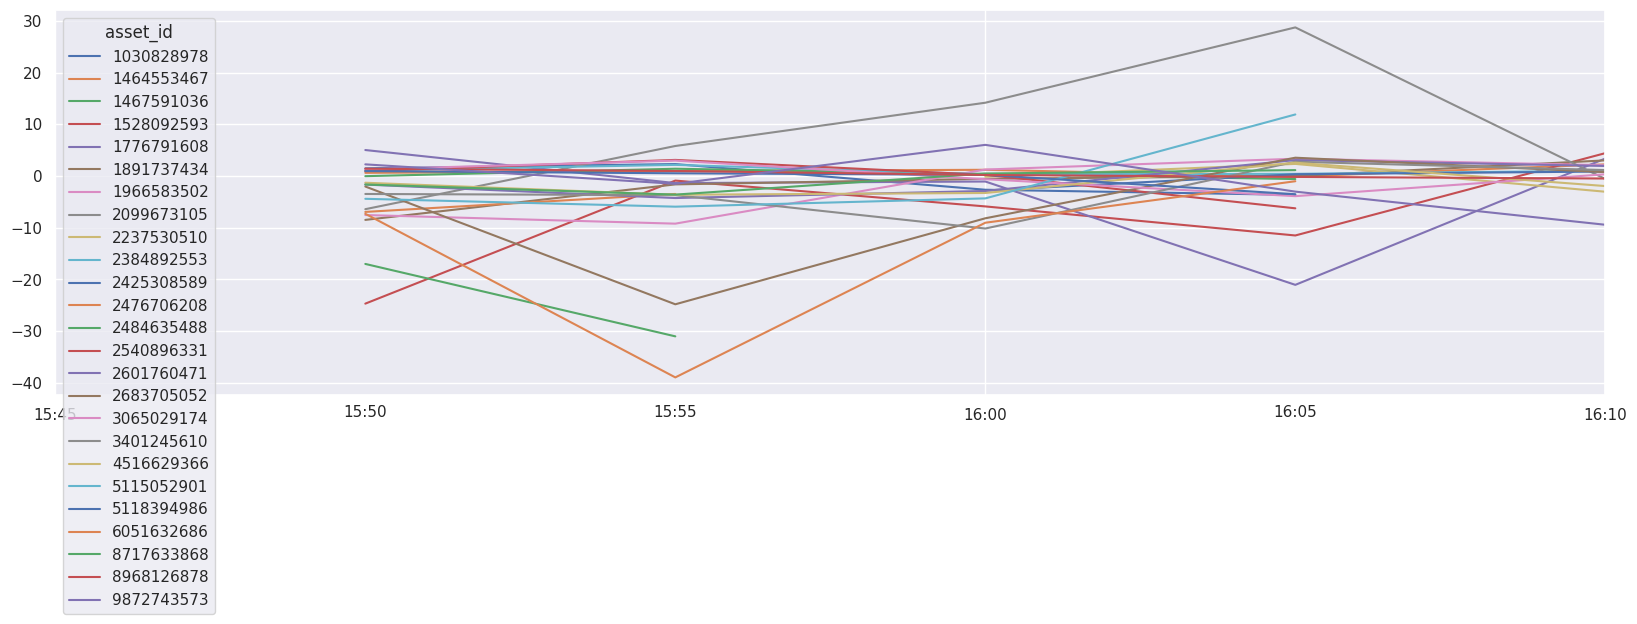

In [73]:
slippage = oms.compute_share_prices_and_slippage(portfolio_df)
hpandas.df_to_str(slippage, num_rows=5, log_level=logging.INFO)
slippage["slippage_in_bps"].plot()

<Axes: >

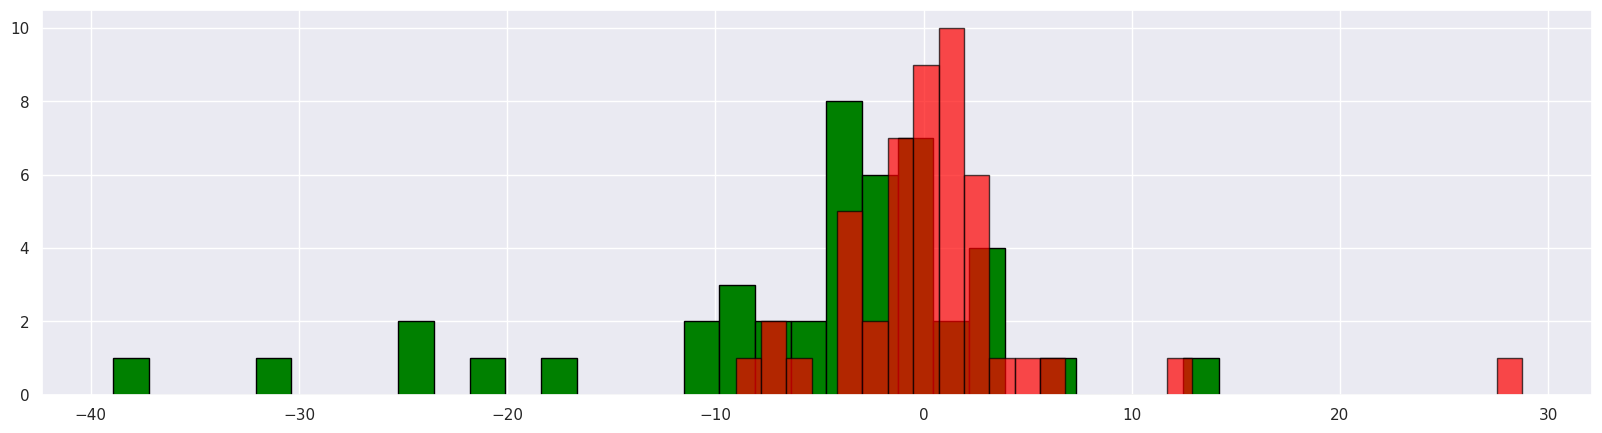

In [74]:
stacked = slippage[["slippage_in_bps", "is_benchmark_profitable"]].stack()
slippage_when_benchmark_profitable = stacked[
    stacked["is_benchmark_profitable"] > 0
]["slippage_in_bps"].rename("slippage_when_benchmark_profitable")
slippage_when_not_benchmark_profitable = stacked[
    stacked["is_benchmark_profitable"] <= 0
]["slippage_in_bps"].rename("slippage_when_not_benchmark_profitable")
slippage_when_benchmark_profitable.hist(bins=31, edgecolor="black", color="green")
slippage_when_not_benchmark_profitable.hist(
    bins=31, alpha=0.7, edgecolor="black", color="red"
)

<Axes: >

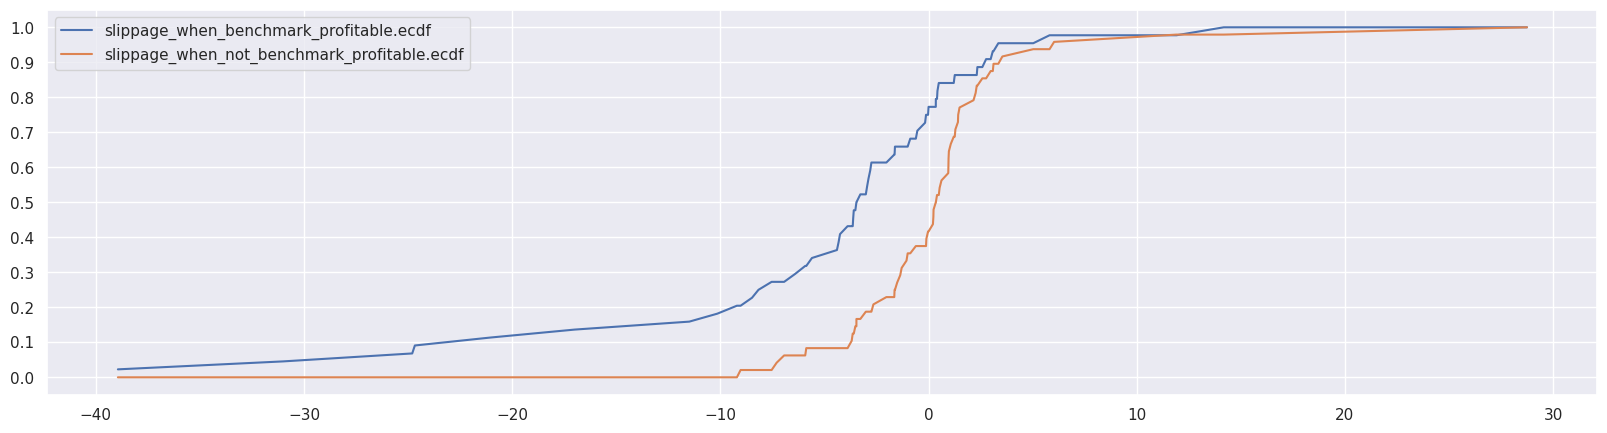

In [75]:
slippage_benchmark_profitability_ecdfs = (
    costatis.compute_and_combine_empirical_cdfs(
        [
            slippage_when_benchmark_profitable,
            slippage_when_not_benchmark_profitable,
        ]
    )
)
slippage_benchmark_profitability_ecdfs.plot(yticks=np.arange(0, 1.1, 0.1))

<Axes: >

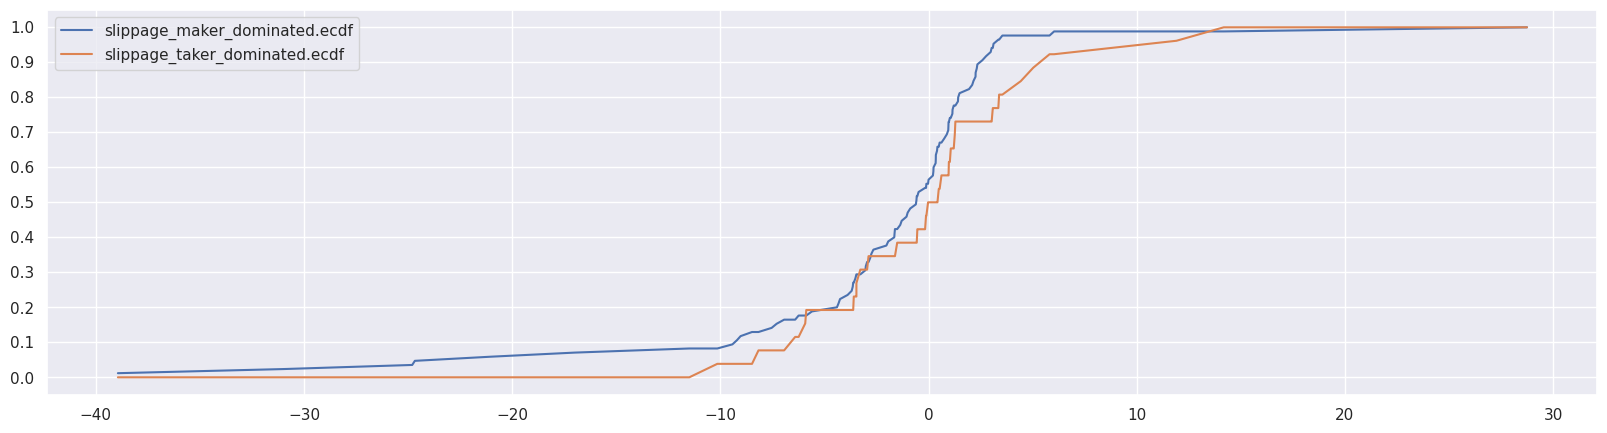

In [76]:
# TODO(*): Clean up and factor out.
maker_ratio_df = bar_fills.copy()
maker_ratio_df["maker_ratio"] = maker_ratio_df["maker_count"] / (
    maker_ratio_df["maker_count"] + maker_ratio_df["taker_count"]
)
maker_ratio_df = maker_ratio_df["maker_ratio"].unstack(level=1)
maker_ratio_df = pd.concat({"maker_ratio": maker_ratio_df}, axis=1)
slippage2 = pd.concat([slippage, maker_ratio_df], axis=1)
stacked2 = slippage2[["slippage_in_bps", "maker_ratio"]].stack()
slippage_maker_dominated = stacked2[stacked2["maker_ratio"] > 0.5][
    "slippage_in_bps"
].rename("slippage_maker_dominated")
slippage_taker_dominated = stacked2[stacked2["maker_ratio"] <= 0.5][
    "slippage_in_bps"
].rename("slippage_taker_dominated")
slippage_maker_taker_ecdfs = costatis.compute_and_combine_empirical_cdfs(
    [slippage_maker_dominated, slippage_taker_dominated]
)
slippage_maker_taker_ecdfs.plot(yticks=np.arange(0, 1.1, 0.1))

## Compute notional costs

In [77]:
notional_costs = omreconc.compute_notional_costs(
    portfolio_df,
    target_position_df,
)
hpandas.df_to_str(notional_costs, num_rows=5, log_level=logging.INFO)

underfill_notional_cost                                                                                                                                                                                                                                                                         slippage_notional                                                                                                                                                                                                                                                                        
asset_id                               1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573        1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
2023-08-15 15:45:00+00:00                     NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN               NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN
2023-08-15 15:50:00+00:00                     NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN           0.00972    0.01482   -0.00056   -0.11592    0.09634    -0.0147   -0.01782    -0.0364     -0.068     0.0146   -0.01984   -0.02188   -0.10166      0.011   -0.01452   -0.02052   0.015656    -0.0621    -0.0106   -0.02106    0.00864    -0.0352     -0.012    0.02448     0.0078
                                              ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...               ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...
2023-08-15 16:05:00+00:00               -0.025964  -0.005984  -0.003207   -0.26971  -0.335867   0.019394   0.025085   0.254339    0.02968  -0.020509   0.027746   -0.27176   0.099569   -0.08888   0.028573   -0.00244  -0.017255   0.000555   0.056519   0.073481  -0.016699        0.0   0.009253  -0.018928  -0.015132          -0.04906   -0.00145   -0.00512    -0.1326    -0.2604        0.0     0.0368     0.3528      0.058   0.004296    0.00508        0.0   -0.01424    -0.0504    0.01215    0.03008  -0.027864    0.02004     0.0545    0.10716  -0.036762    -0.0136      0.021   -0.00136    -0.0076
2023-08-15 16:10:00+00:00                     NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN               NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        N

<Axes: >

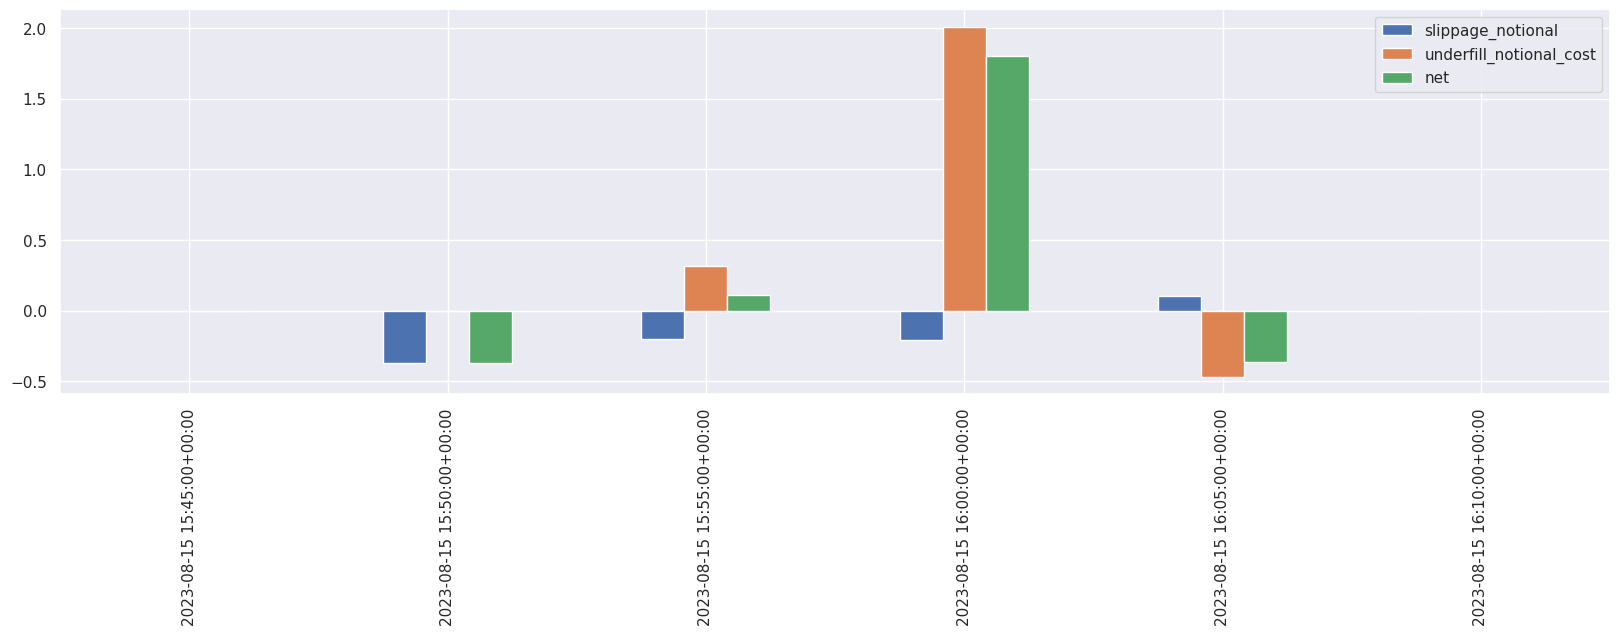

In [78]:
omreconc.summarize_notional_costs(notional_costs, "by_bar").plot(kind="bar")

<Axes: xlabel='asset_id'>

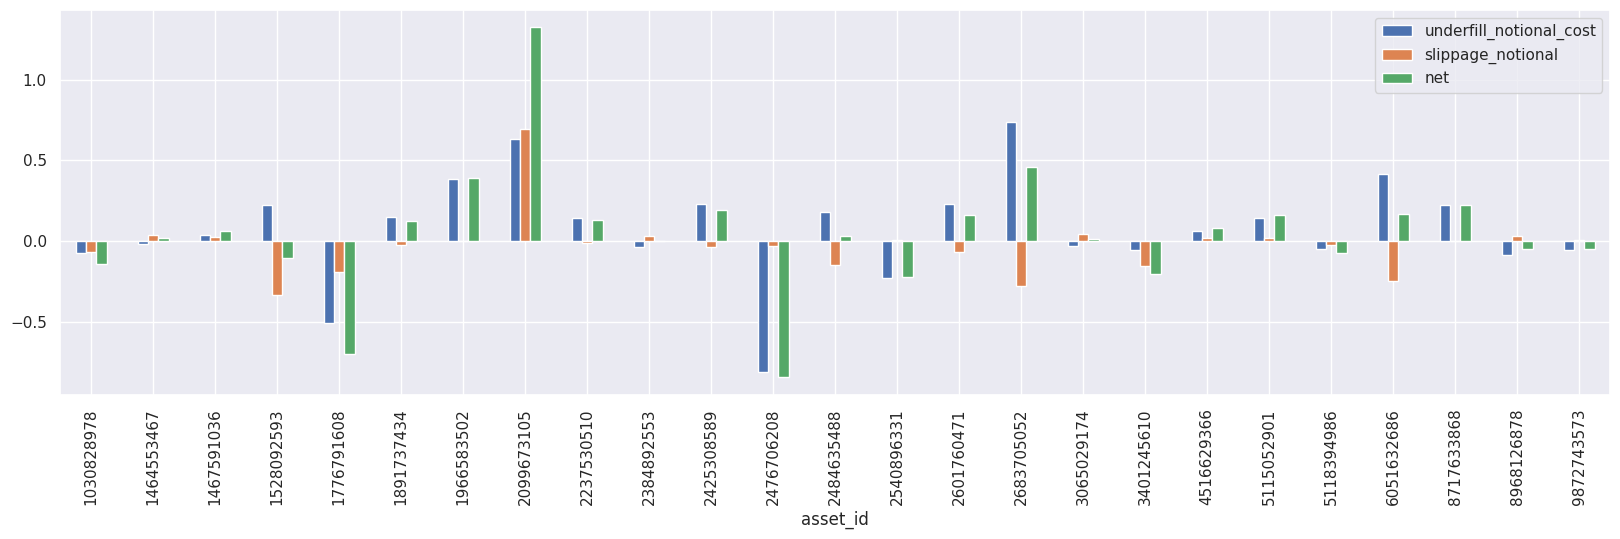

In [79]:
omreconc.summarize_notional_costs(notional_costs, "by_asset").plot(kind="bar")

In [80]:
omreconc.summarize_notional_costs(notional_costs, "by_bar").sum()

slippage_notional         -0.677294
underfill_notional_cost    1.852088
net                        1.174794
dtype: float64

In [81]:
portfolio_stats_df = cofinanc.compute_bar_metrics(
    portfolio_df["holdings_notional"],
    -portfolio_df["executed_trades_notional"],
    portfolio_df["pnl"],
    compute_extended_stats=True,
)

In [82]:
portfolio_stats_df.head()

,pnl,gross_volume,net_volume,gmv,nmv,gpc,npc,wnl
2023-08-15 15:45:00+00:00,0.000000,NaN,NaN,0.000000,0.000000,0.0,0.0,0.0
2023-08-15 15:50:00+00:00,0.369724,2539.54834,-324.87194,2540.279296,-324.502216,25.0,3.0,7.0
2023-08-15 15:55:00+00:00,-0.599542,1823.75669,214.48839,1535.255160,-110.613368,25.0,1.0,-1.0
2023-08-15 16:00:00+00:00,0.541374,2501.43457,231.82455,3329.811092,121.752556,25.0,5.0,5.0
2023-08-15 16:05:00+00:00,-0.106828,2602.43143,-706.32067,1743.936862,-584.674942,25.0,-7.0,5.0


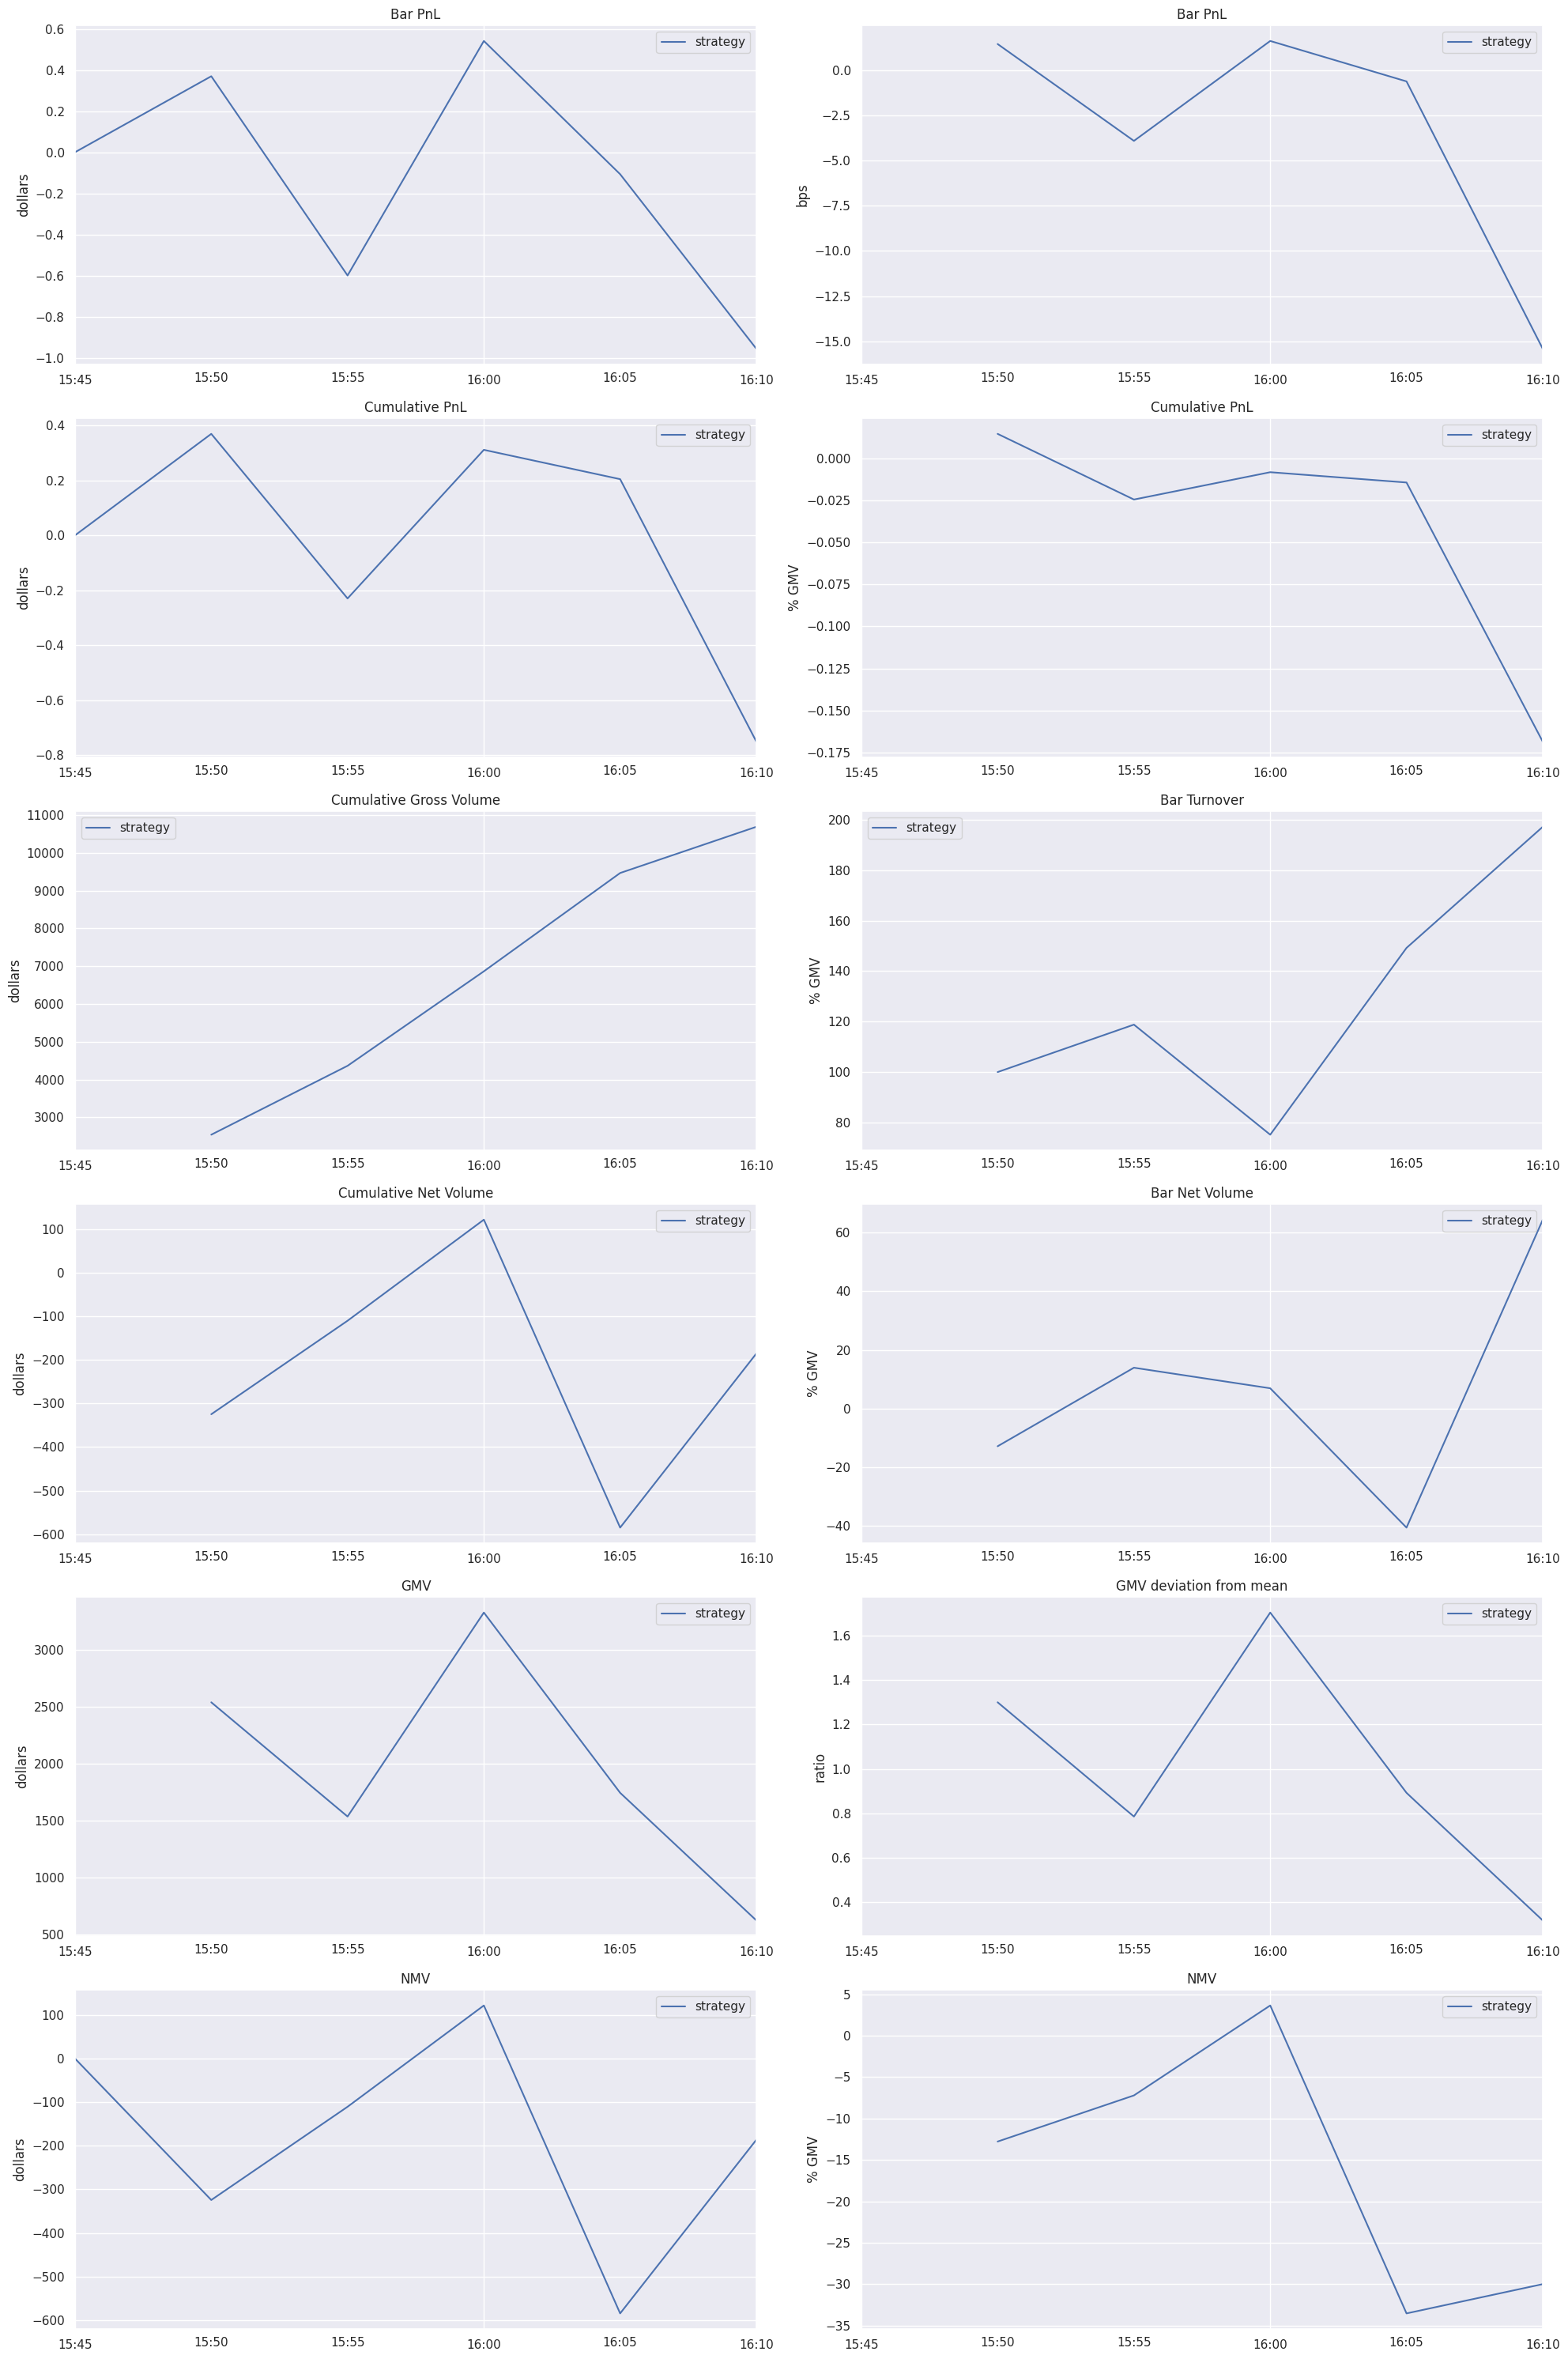

In [83]:
coplotti.plot_portfolio_stats(portfolio_stats_df)

# Config after notebook run

In [84]:
print(config.to_string(mode="verbose"))

meta (marked_as_used=False, writer=None, val_type=core.config.config_.Config): 
  id_col (marked_as_used=True, writer=/tmp/ipykernel_21534/2146073187.py::4::<module>, val_type=str): asset_id
  use_historical (marked_as_used=False, writer=None, val_type=bool): True
system_log_dir (marked_as_used=True, writer=/tmp/ipykernel_21534/882895056.py::2::<module>, val_type=str): /shared_data/ecs/test/twap_experiment/20230815_1
ohlcv_market_data (marked_as_used=False, writer=None, val_type=core.config.config_.Config): 
  vendor (marked_as_used=True, writer=/tmp/ipykernel_21534/1415057322.py::4::<module>, val_type=str): CCXT
  mode (marked_as_used=True, writer=/tmp/ipykernel_21534/1415057322.py::10::<module>, val_type=str): trade
  universe (marked_as_used=False, writer=None, val_type=core.config.config_.Config): 
    universe_version (marked_as_used=True, writer=/tmp/ipykernel_21534/1415057322.py::1::<module>, val_type=str): v7.1
    test_asset_id (marked_as_used=True, writer=/tmp/ipykernel_21534